# Caustics

In [1]:
# %pip install -U -r requirements.txt

In [2]:
import matplotlib
matplotlib.__version__

'3.9.2'

In [3]:
import matplotlib.gridspec as gs


In [4]:
import numpy as np


In [5]:
import os
import numpy as np
# import imageio
import cv2

# the higher PRECISION, the bigger the file
PRECISION = 4  # debugging
PRECISION = 10 # medium quality
PRECISION = 12 # good quality
# PRECISION = 14 # very good quality
# PRECISION = 15 # for production

# https://docs.python.org/3/library/dataclasses.html?highlight=dataclass#module-dataclasses
from dataclasses import dataclass

@dataclass
class init:
    figpath: str = '2024-08-29_caustique-bands' # Folder to store images
    # phi: float = 1.61803 # beauty is gold
    tag: str = 'caustique' # Tag
    ext: str = 'png' # Extension for output
    nx: int = 13*2**PRECISION # number of pixels (vertical)
    ny: int = 1*2**PRECISION # number of pixels (horizontal)
    nframe: int = 1 # number of frames
    bin_dens: int = 2 # relative bin density
    bin_spectrum: int = 1 # bin spacing in spectrum (lower is more CPU)
    seed: int = 2024 # seed for RNG
    H: float = 40.0 # depth of the pool
    variation: float = .20 # variation of diffraction index: http://www.philiplaven.com/p20.html 1.40 at 400 nm and 1.37 at 700nm makes a 2% variation
    scale: float = .95*2**PRECISION # period in pixels
    B_sf: float = 1.61 # bandwidth in sf
    V_Y: float = 0.3 # horizontal speed
    V_X: float = 0.3 # vertical speed
    B_V: float = 1.0 # bandwidth in speed
    zmin: float = 0.10 # relative minimal value of wave height at the top to generate a gradient (set to 1. to have no gradient)
    # theta: float = 2*np.pi*(2-1.61803) # angle with the horizontal
    theta: float = np.pi/2 # angle with the horizontal
    B_theta: float = 60*np.pi/180 # bandwidth in theta
    min_lum: float = .01 # global diffusion level for the rendering giving the pedestal value
    n_bits: int = 16 # bits to save images
    gamma: float = 3. # Gamma exponant to convert luminosity to luminance
    fps: float = 18 # frames per second
    multispectral: bool = True # Compute caustics on the full spectrogram.
    do_cache: bool = True # Cache intermediate output.
    verbose: bool = False # Displays more verbose output.
    do_display: bool = False # Displays images in notebook.
    do_recompute: bool = False # Restart each computation    

In [6]:
opt = init()
print(f'Saving our simulations in={opt.figpath}')

Saving our simulations in=2024-08-29_caustique-bands


In [7]:
# if opt.nframe==1: opt.ext = 'png'

In [8]:
from pprint import pprint
pprint(opt)

init(figpath='2024-08-29_caustique-bands',
     tag='caustique',
     ext='png',
     nx=53248,
     ny=4096,
     nframe=1,
     bin_dens=2,
     bin_spectrum=1,
     seed=2024,
     H=40.0,
     variation=0.2,
     scale=3891.2,
     B_sf=1.61,
     V_Y=0.3,
     V_X=0.3,
     B_V=1.0,
     zmin=0.1,
     theta=1.5707963267948966,
     B_theta=1.0471975511965976,
     min_lum=0.01,
     n_bits=16,
     gamma=3.0,
     fps=18,
     multispectral=True,
     do_cache=True,
     verbose=False,
     do_display=False,
     do_recompute=False)


In [9]:
screen_size_cm = 100 # cm
cm_by_inch = 2.54
screen_size_in = screen_size_cm/cm_by_inch
dpi = (opt.nx // opt.bin_dens) / screen_size_in
print(f'Screen size={screen_size_cm}cm={screen_size_in:.3f}in, dpi={dpi:.0f}dpi')

Screen size=100cm=39.370in, dpi=676dpi


## utilities

Transfoming a sequence of PNG frames into gif or mp4:

In [10]:
def make_gif(gifname, fnames, fps, do_delete=True):
    with imageio.get_writer(gifname, mode='I', fps=fps) as writer:
        for fname in fnames:
            writer.append_data(imageio.imread(fname))

    from pygifsicle import optimize
    optimize(str(gifname))
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return gifname

# https://moviepy.readthedocs.io/en/latest/getting_started/videoclips.html#imagesequenceclip
def make_mp4(mp4name, fnames, fps, do_delete=True):
    import moviepy.editor as mpy
    clip = mpy.ImageSequenceClip(fnames, fps=fps)
    clip.write_videofile(mp4name, fps=fps, codec='libx264', verbose=False, logger=None)
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return mp4name


Utilities to compute the spectrum of the blue sky and convert them later to RGB values (check out https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for details)

In [11]:
from lambda2color import Lambda2color, xyz_from_xy

# borrowed from https://github.com/gummiks/gummiks.github.io/blob/master/scripts/astro/planck.py
def planck(wav, T):
    import scipy.constants as const
    c = const.c # c = 3.0e+8
    h = const.h # h = 6.626e-34
    k = const.k # k = 1.38e-23
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a / ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

def scattering(wav, a=0.005, p=1.3, b=0.45):
    """
    b is  proportionate  to  the  column  density  of  aerosols
    along  the  path  of  sunlight,  from  outside  the  atmosphere
    to  the  point  of  observation
    
    see https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for more details

    """
    # converting wav in µm:
    intensity = np.exp(-a/((wav/1e-6)**4)) # Rayleigh extinction by nitrogen
    intensity *= (wav/1e-6)**-4
    intensity *= np.exp(-b/((wav/1e-6)**p)) # Aerosols
    return intensity

## computing the caustics

In [12]:
import matplotlib
subplotpars = matplotlib.gridspec.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import shutil
import hashlib
import MotionClouds as mc

class Caustique:
    def __init__(self, opt):
        """
        Image coordinates follow 'ij' indexing, that is,
        * their origin at the top left,
        * the X axis is vertical and goes "down",
        * the Y axis is horizontal and goes "right".

        """
        self.mc = mc
        self.ratio = opt.ny/opt.nx # ratio between height and width (>1 for portrait, <1 for landscape)
        X = np.linspace(0, 1, opt.nx, endpoint=False) # vertical
        Y = np.linspace(0, self.ratio, opt.ny, endpoint=False) # horizontal
        self.xv, self.yv = np.meshgrid(X, Y, indexing='ij')
        self.opt = opt
        # https://stackoverflow.com/questions/16878315/what-is-the-right-way-to-treat-python-argparse-namespace-as-a-dictionary
        self.d = vars(opt)
        os.makedirs(self.opt.figpath, exist_ok=True)
        self.cachepath = os.path.join('/tmp', self.opt.figpath)
        if opt.verbose: print(f'{self.cachepath=}')
        os.makedirs(self.cachepath, exist_ok=True)

        # a standard white:
        # illuminant_D65 = xyz_from_xy(0.3127, 0.3291), 
        illuminant_sun = xyz_from_xy(0.325998, 0.335354)
        # color conversion class
        self.cs_srgb = Lambda2color(red=xyz_from_xy(0.64, 0.33),
                               green=xyz_from_xy(0.30, 0.60),
                               blue=xyz_from_xy(0.15, 0.06),
                               white=illuminant_sun)
        self.wavelengths = self.cs_srgb.cmf[:, 0]*1e-9
        self.N_wavelengths = len(self.wavelengths)
        # multiply by the spectrum of the sky
        intensity5800 = planck(self.wavelengths, 5800.)
        scatter = scattering(self.wavelengths)
        self.spectrum_sky = intensity5800 * scatter
        self.spectrum_sky /= self.spectrum_sky.max()

    def wave(self, do_cache=None):
        filename = f'{self.cachepath}/{self.opt.tag}_wave.npy'
        if do_cache is None: do_cache = self.opt.do_cache
        if os.path.isfile(filename) and not(self.opt.do_recompute) and do_cache:
            z = np.load(filename)
        else:
            # A simplistic model of a wave using https://github.com/NeuralEnsemble/MotionClouds
            fx, fy, ft = mc.get_grids(self.opt.nx, self.opt.ny, self.opt.nframe)
            env = mc.envelope_gabor(fx, fy, ft, V_X=self.opt.V_Y, V_Y=self.opt.V_X, B_V=self.opt.B_V,
                                    sf_0=1./self.opt.scale, B_sf=self.opt.B_sf/self.opt.scale,
                                    theta=self.opt.theta, B_theta=self.opt.B_theta)
            z = mc.rectif(mc.random_cloud(env, seed=self.opt.seed))
            if do_cache: np.save(filename, z)
        return z * np.linspace(self.opt.zmin, 1., self.opt.nx)[:, None, None]

    def transform(self, z_, modulation=1., edge_order=2):
        xv, yv = self.xv.copy(), self.yv.copy()

        # dzdx = z_ - np.roll(z_, 1, axis=0)
        # dzdy = z_ - np.roll(z_, 1, axis=1)

        # https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
        # dzdx = np.gradient(z_, axis=0, edge_order=edge_order)
        # dzdy = np.gradient(z_, axis=1, edge_order=edge_order)
        dzdx, dzdy = np.gradient(z_, edge_order=edge_order)

        xv = xv + modulation * self.opt.H * dzdx
        yv = yv + modulation * self.opt.H * dzdy

        xv = np.mod(xv, 1)
        yv = np.mod(yv, self.ratio)

        return xv, yv

    def get_filename(self):
        # output filename        
        md5 = hashlib.sha224((self.opt.figpath + self.opt.tag).encode()).hexdigest()[:8] # an unique identifier for future tagging
        output_filename = f'{self.opt.figpath}/{self.opt.tag}_{md5}.{self.opt.ext}'
        return output_filename

    def plot(self, z, image=None, do_color=True, dpi=dpi):
        """
        
        dpi: output resolution - sets the figure size as we ensure there is a one to one correspondance between pixels in the data and the output image
        """

        output_filename = self.get_filename()
        if os.path.isfile(output_filename) and not(self.opt.do_recompute):
            return output_filename
        else:
            # 1/ do the raytracing of image through z:
            binsx, binsy = self.opt.nx//self.opt.bin_dens, self.opt.ny//self.opt.bin_dens

            # a fixed image in degree of contrast (from 0=black to 1=white)
            if image is None: image = np.ones((self.opt.nx, self.opt.ny))

            #hist = self.do_raytracing(z)
            binsx, binsy = self.opt.nx//self.opt.bin_dens, self.opt.ny//self.opt.bin_dens


            if self.opt.multispectral:

                #image_rgb = self.cs_srgb.spec_to_rgb(hist)
                image_rgb = np.zeros((self.opt.nx//self.opt.bin_dens,  self.opt.ny//self.opt.bin_dens, 3, self.opt.nframe))
                for i_frame in trange(self.opt.nframe):
                    for i_wavelength in trange(self.opt.bin_spectrum//2, self.N_wavelengths, self.opt.bin_spectrum):
                        modulation = 1. + self.opt.variation/2 - self.opt.variation*i_wavelength/self.N_wavelengths
                        xv, yv = self.transform(z[:, :, i_frame], modulation=modulation)
                        hist_, _, _ = np.histogram2d(xv.ravel(), yv.ravel(),
                                                     bins=[binsx, binsy],
                                                     weights=image.ravel(),
                                                     range=[[0, 1], [0, self.ratio]],
                                                     density=True)

                        # we convert the spectrum into a color
                        spec = np.zeros((self.N_wavelengths))
                        spec[i_wavelength] = 1
                        rgb = self.cs_srgb.spec_to_rgb(spec)
                        rgb *= self.spectrum_sky[i_wavelength]
                        # we add the color to the image
                        image_rgb[:, :, :, i_frame] += hist_[:, :, None] * rgb[None, None, :]

                image_rgb -= image_rgb.min()
                image_rgb /= image_rgb.max()
            else:
                hist = np.zeros((binsx, binsy, self.opt.nframe))
                for i_frame in trange(self.opt.nframe):
                    xv, yv = self.transform(z[:, :, i_frame])
                    hist_, _, _ = np.histogram2d(xv.ravel(), yv.ravel(),
                                                        bins=[binsx, binsy],
                                                        range=[[0, 1], [0, self.ratio]],
                                                        density=True)
                #hist /= hist.max()

            # 2/ transform light into image:
            fnames = []
            for i_frame in trange(self.opt.nframe):
                fig, ax = plt.subplots(figsize=(self.opt.ny/self.opt.bin_dens/dpi, self.opt.nx/self.opt.bin_dens/dpi), subplotpars=subplotpars)
                if self.opt.multispectral:
                    image_array = image_rgb[:, :, :, i_frame] ** (1/self.opt.gamma)
                    ax.imshow(image_array, vmin=0, vmax=1)
                else:
                    if do_color:
                        bluesky = np.array([0.268375, 0.283377]) # xyz
                        sun = np.array([0.325998, 0.335354]) # xyz
                        # ax.pcolormesh(edge_y, edge_x, hist[:, :, i_frame], vmin=0, vmax=1, cmap=plt.cm.Blues_r)
                        # https://en.wikipedia.org/wiki/CIE_1931_color_space#Mixing_colors_specified_with_the_CIE_xy_chromaticity_diagram
                        L1 = 1 - hist[:, :, i_frame]
                        L2 = hist[:, :, i_frame]
                        image_denom = L1 / bluesky[1] + L2 / sun[1]
                        image_x = (L1 * bluesky[0] / bluesky[1] + L2 * sun[0] / sun[1]) / image_denom
                        image_y = (L1 + L2) / image_denom 
                        image_xyz = np.dstack((image_x, image_y, 1 - image_x - image_y))
                        image_rgb = self.cs_srgb.xyz_to_rgb(image_xyz)
                        image_L = (self.opt.min_lum + (1-self.opt.min_lum)* L2) ** (1/self.opt.gamma)
                        image_array = image_L[:, :, None]*image_rgb
                        ax.imshow(image_array, vmin=0, vmax=1)
                    else:
                        ax.imshow(1-image_L, vmin=0, vmax=1)

                fname = f'{self.cachepath}/{self.opt.tag}_frame_{i_frame:04d}.png'
                
                # fig.savefig(fname, dpi=dpi)
                np_dtype = np.uint8 if self.opt.n_bits==8 else np.uint16
                # imageio.imsave(fname, image_array.astype(np_dtype), dpi=dpi, extension=opt.ext)
                cv2.imwrite(fname, (image_array*(2**self.opt.n_bits-1)).astype(np_dtype))
                fnames.append(fname)
                plt.close(fig)

            if self.opt.nframe==1:
                shutil.move(fname, output_filename)
                return output_filename
            else:
                if self.opt.ext == 'gif':
                    return make_gif(output_filename, fnames, fps=self.opt.fps)
                else:
                    return make_mp4(output_filename, fnames, fps=self.opt.fps)

    def show(self, output_filename, width=1024):
        from IPython.display import HTML, Image, display
        if self.opt.nframe==1:
            # display(Image(url=output_filename.replace(self.opt.ext, 'png'), width=width))
            display(Image(url=output_filename, width=width))
        else:
            if self.opt.ext == 'gif':
                return display(Image(url=output_filename, width=width))
            else:
                #import moviepy.editor as mpy
                #return mpy.ipython_display(output_filename, width=width)
                # https://github.com/NeuralEnsemble/MotionClouds/blob/master/MotionClouds/MotionClouds.py#L858
                opts = ' loop="1" autoplay="1" controls '
                html = HTML(f'<video {opts} src="{output_filename}" type="video/{self.opt.ext}" width={width}\>')
                html.reload()
                return display(html)

<>:198: SyntaxWarning: invalid escape sequence '\>'
<>:198: SyntaxWarning: invalid escape sequence '\>'
/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_12564/4028701564.py:198: SyntaxWarning: invalid escape sequence '\>'
  html = HTML(f'<video {opts} src="{output_filename}" type="video/{self.opt.ext}" width={width}\>')


# a simple caustics

## generating the caustics

In [13]:
c = Caustique(opt)
z = c.wave()
z.shape

(53248, 4096, 1)

In [14]:
type = 'grating'

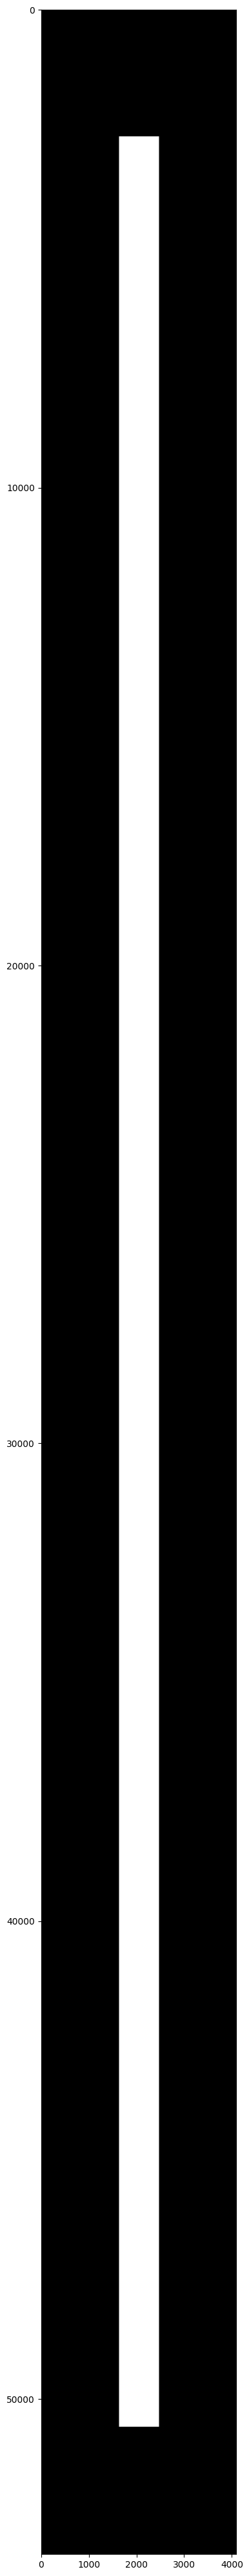

In [15]:
def generate_image(nx, ny, periods=.5, threshold=0.80, radius=.9):
    Y, X = np.meshgrid(np.linspace(-1, 1, ny, endpoint=True), np.linspace(-1, 1, nx, endpoint=True))
    image = (np.cos(2*np.pi*Y*periods) > threshold)*1.
    # image += (np.cos(2*np.pi*Y*periods) > threshold)*1.
    # image = (image>=1) * 1.
    image *= (X**2 < radius**2) * (Y**2 < radius**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny)

fig, ax = plt.subplots(figsize=(opt.ny/opt.bin_dens/dpi, opt.nx/opt.bin_dens/dpi), subplotpars=subplotpars)

ax.imshow(image, cmap='gray');

In [16]:
c = Caustique(opt)
output_filename = c.plot(z, image)

In [17]:
c.show(output_filename)

# exploring parameters

In [18]:
N_scan = 7
base = 4

## water depth

In [19]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 10.000 -> output_filename='2024-08-29_caustique-bands/caustique_H_10.000_153e5c66.png' 


H = 15.874 -> output_filename='2024-08-29_caustique-bands/caustique_H_15.874_1b6a450a.png' 


H = 25.198 -> output_filename='2024-08-29_caustique-bands/caustique_H_25.198_ea287c35.png' 


H = 40.000 -> output_filename='2024-08-29_caustique-bands/caustique_H_40.000_8463edb5.png' 


H = 63.496 -> output_filename='2024-08-29_caustique-bands/caustique_H_63.496_4b7997f1.png' 


H = 100.794 -> output_filename='2024-08-29_caustique-bands/caustique_H_100.794_45f7e9e2.png' 


H = 160.000 -> output_filename='2024-08-29_caustique-bands/caustique_H_160.000_2f8779c2.png' 


## refraction index variation

In [20]:
for variation_ in np.logspace(-2, 0, N_scan, base=10, endpoint=False):
    opt = init()
    c = Caustique(opt)
    c.opt.variation = variation_
    c.opt.tag = f'{opt.tag}_variation_{variation_:.3f}'

    output_filename = c.plot(z, image)
    print(f'variation = {variation_:.3f}  -> {output_filename=}')
    if c.opt.do_display: c.show(output_filename)

variation = 0.010  -> output_filename='2024-08-29_caustique-bands/caustique_variation_0.010_3c55538d.png'


variation = 0.019  -> output_filename='2024-08-29_caustique-bands/caustique_variation_0.019_408835ef.png'


variation = 0.037  -> output_filename='2024-08-29_caustique-bands/caustique_variation_0.037_5a5d40e3.png'


variation = 0.072  -> output_filename='2024-08-29_caustique-bands/caustique_variation_0.072_78279c42.png'


variation = 0.139  -> output_filename='2024-08-29_caustique-bands/caustique_variation_0.139_fdb18b7f.png'


variation = 0.268  -> output_filename='2024-08-29_caustique-bands/caustique_variation_0.268_859a5de7.png'


variation = 0.518  -> output_filename='2024-08-29_caustique-bands/caustique_variation_0.518_bcd6efca.png'


## post-processing

In [21]:
for variable in ['gamma', 'min_lum']: 
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        opt = init()
        c = Caustique(opt)
        c.d[variable] *= modul
        c.opt.tag = f'{c.opt.tag}_{variable}_modul_{modul:.3f}'
        
        output_filename = c.plot(z, image)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if c.opt.do_display: c.show(output_filename)

======gamma======


gamma=gamma(default)*0.250=7.500E-01 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_0.250_aed91770.png'


gamma=gamma(default)*0.397=1.191E+00 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_0.397_ba62e1c7.png'


gamma=gamma(default)*0.630=1.890E+00 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_0.630_cfe2ee05.png'


gamma=gamma(default)*1.000=3.000E+00 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_1.000_2d331403.png'


gamma=gamma(default)*1.587=4.762E+00 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_1.587_c87f783a.png'


gamma=gamma(default)*2.520=7.560E+00 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_2.520_0b59a929.png'


gamma=gamma(default)*4.000=1.200E+01 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_4.000_a55584c7.png'
======min_lum======


min_lum=min_lum(default)*0.250=2.500E-03 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_0.250_8afb877a.png'


min_lum=min_lum(default)*0.397=3.969E-03 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_0.397_76a4fd49.png'


min_lum=min_lum(default)*0.630=6.300E-03 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_0.630_c4389f7e.png'


min_lum=min_lum(default)*1.000=1.000E-02 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_1.000_1cff0d98.png'


min_lum=min_lum(default)*1.587=1.587E-02 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_1.587_8893da46.png'


min_lum=min_lum(default)*2.520=2.520E-02 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_2.520_7249fbf2.png'


min_lum=min_lum(default)*4.000=4.000E-02 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_4.000_664cb2c0.png'


## other instances of the wave

In [22]:
for seed_increment in range(10):
    opt = init()
    c = Caustique(opt)
    c.d['seed'] = c.d['seed'] + seed_increment
    c.opt.tag = f'{c.opt.tag}_seed_{c.d['seed']}'
    
    z = c.wave()
    output_filename = c.plot(z, image)
    print(f'seed={c.d['seed']} -> {output_filename=}')
    if c.opt.do_display: c.show(output_filename)

seed=2024 -> output_filename='2024-08-29_caustique-bands/caustique_seed_2024_061fc695.png'


seed=2025 -> output_filename='2024-08-29_caustique-bands/caustique_seed_2025_b699fc73.png'


seed=2026 -> output_filename='2024-08-29_caustique-bands/caustique_seed_2026_0224d266.png'


seed=2027 -> output_filename='2024-08-29_caustique-bands/caustique_seed_2027_613fa57d.png'


seed=2028 -> output_filename='2024-08-29_caustique-bands/caustique_seed_2028_54c0e239.png'


seed=2029 -> output_filename='2024-08-29_caustique-bands/caustique_seed_2029_d2797b24.png'


seed=2030 -> output_filename='2024-08-29_caustique-bands/caustique_seed_2030_faf4c45b.png'


seed=2031 -> output_filename='2024-08-29_caustique-bands/caustique_seed_2031_89e1e16d.png'


seed=2032 -> output_filename='2024-08-29_caustique-bands/caustique_seed_2032_b7b43343.png'


seed=2033 -> output_filename='2024-08-29_caustique-bands/caustique_seed_2033_88c7cd8a.png'


## other variables on the wave

In [23]:
for variable in ['scale', 'B_sf', 'theta',  'B_theta', 'zmin']: #  'V_Y', 'V_X', 'B_V', 
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        opt = init()
        c = Caustique(opt)
        c.d[variable] *= modul
        c.opt.tag = f'{c.opt.tag}_{variable}_modul_{modul:.3f}'
        
        output_filename = c.get_filename()
        if os.path.isfile(output_filename) and not(c.opt.do_recompute):            
            z = c.wave(do_cache=False)
            output_filename_ = c.plot(z, image)
            assert(output_filename == output_filename_)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if c.opt.do_display: c.show(output_filename)

======scale======


scale=scale(default)*0.250=9.728E+02 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_0.250_e0e3dfd4.png'


scale=scale(default)*0.397=1.544E+03 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_0.397_8a7115a0.png'


scale=scale(default)*0.630=2.451E+03 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_0.630_2af29e7a.png'


scale=scale(default)*1.000=3.891E+03 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_1.000_beb494bc.png'


scale=scale(default)*1.587=6.177E+03 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_1.587_d8a53cc3.png'


scale=scale(default)*2.520=9.805E+03 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_2.520_d8b6ab95.png'


scale=scale(default)*4.000=1.556E+04 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_4.000_97e348c5.png'
======B_sf======


B_sf=B_sf(default)*0.250=4.025E-01 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_0.250_d6aa7d80.png'


B_sf=B_sf(default)*0.397=6.389E-01 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_0.397_34f80ff2.png'


B_sf=B_sf(default)*0.630=1.014E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_0.630_94fe18ca.png'


B_sf=B_sf(default)*1.000=1.610E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_1.000_c5d31727.png'


B_sf=B_sf(default)*1.587=2.556E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_1.587_990dd697.png'


B_sf=B_sf(default)*2.520=4.057E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_2.520_238ecb60.png'


B_sf=B_sf(default)*4.000=6.440E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_4.000_8db46ff2.png'
======theta======


theta=theta(default)*0.250=3.927E-01 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_0.250_ad01e86a.png'


theta=theta(default)*0.397=6.234E-01 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_0.397_e6c909d6.png'


theta=theta(default)*0.630=9.895E-01 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_0.630_d30c5197.png'


theta=theta(default)*1.000=1.571E+00 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_1.000_f53bb7d2.png'


theta=theta(default)*1.587=2.493E+00 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_1.587_694de02e.png'


theta=theta(default)*2.520=3.958E+00 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_2.520_cf29a0f7.png'


theta=theta(default)*4.000=6.283E+00 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_4.000_33e1ca4a.png'
======B_theta======


B_theta=B_theta(default)*0.250=2.618E-01 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_0.250_95bceb2c.png'


B_theta=B_theta(default)*0.397=4.156E-01 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_0.397_21587797.png'


B_theta=B_theta(default)*0.630=6.597E-01 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_0.630_d9dcab68.png'


B_theta=B_theta(default)*1.000=1.047E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_1.000_40cfadaf.png'


B_theta=B_theta(default)*1.587=1.662E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_1.587_d2c73741.png'


B_theta=B_theta(default)*2.520=2.639E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_2.520_4112b8bf.png'


B_theta=B_theta(default)*4.000=4.189E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_4.000_0fd04c76.png'
======zmin======


zmin=zmin(default)*0.250=2.500E-02 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_0.250_1b6360ce.png'


zmin=zmin(default)*0.397=3.969E-02 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_0.397_e554a286.png'


zmin=zmin(default)*0.630=6.300E-02 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_0.630_423d1a71.png'


zmin=zmin(default)*1.000=1.000E-01 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_1.000_df5cb709.png'


zmin=zmin(default)*1.587=1.587E-01 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_1.587_17261ce8.png'


zmin=zmin(default)*2.520=2.520E-01 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_2.520_36517417.png'


zmin=zmin(default)*4.000=4.000E-01 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_4.000_1ff55d14.png'


## shining a grating image to the wave

In [24]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_{type}-image'
output_filename = c.plot(z, image)
c.show(output_filename)

In [25]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_{type}-image_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 10.000 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_H_10.000_40872493.png' 


H = 15.874 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_H_15.874_0efb4c4a.png' 


H = 25.198 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_H_25.198_7ef7a83b.png' 


H = 40.000 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_H_40.000_3e027d72.png' 


H = 63.496 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_H_63.496_ef991df5.png' 


H = 100.794 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_H_100.794_ff997582.png' 


H = 160.000 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_H_160.000_9f65861d.png' 


In [26]:
for threshold in np.linspace(0, 1, N_scan+2, endpoint=True)[1:-1]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

0.125 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_threshold=0.125_a1972b4e.png' 


0.250 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_threshold=0.250_a6111596.png' 


0.375 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_threshold=0.375_371ef1d8.png' 


0.500 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_threshold=0.500_f6eaeb24.png' 


0.625 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_threshold=0.625_9d96d959.png' 


0.750 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_threshold=0.750_828cf286.png' 


0.875 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_threshold=0.875_e8e80cbe.png' 


In [27]:
for radius in np.linspace(0, 1, N_scan+1)[1:]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{radius=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=radius)
    output_filename = c.plot(z, image)
    print(f'{radius=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

radius=0.143 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_radius=0.143_59eb3d16.png' 


radius=0.286 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_radius=0.286_df7f48b3.png' 


radius=0.429 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_radius=0.429_c2f8d199.png' 


radius=0.571 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_radius=0.571_3e186426.png' 


radius=0.714 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_radius=0.714_ec976669.png' 


radius=0.857 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_radius=0.857_5f23c6eb.png' 


radius=1.000 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_radius=1.000_564212b3.png' 


In [28]:
for periods in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{periods=:.2e}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=periods)
    output_filename = c.plot(z, image)
    print(f'{periods=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

periods=1.000 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_periods=1.00e+00_fb012ca2.png' 


periods=1.468 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_periods=1.47e+00_66a6bf8a.png' 


periods=2.154 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_periods=2.15e+00_5026edd6.png' 


periods=3.162 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_periods=3.16e+00_508330c4.png' 


periods=4.642 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_periods=4.64e+00_9ecf5681.png' 


periods=6.813 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_periods=6.81e+00_90dd3377.png' 


periods=10.000 -> output_filename='2024-08-29_caustique-bands/caustique_grating-image_periods=1.00e+01_8fdb3822.png' 


In [29]:
for variable in ['scale', 'B_sf', 'theta',  'B_theta', 'gamma', 'min_lum', 'zmin']: #  'V_Y', 'V_X', 'B_V', 
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        opt = init()
        c = Caustique(opt)
        c.d[variable] *= modul
        c.opt.tag = f'{c.opt.tag}_{variable}_modul_{modul:.3f}'
        z = c.wave(do_cache=False)
        image = generate_image(nx=c.opt.nx, ny=c.opt.ny)
        output_filename = c.plot(z, image)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if c.opt.do_display: c.show(output_filename)

======scale======


scale=scale(default)*0.250=9.728E+02 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_0.250_e0e3dfd4.png'


scale=scale(default)*0.397=1.544E+03 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_0.397_8a7115a0.png'


scale=scale(default)*0.630=2.451E+03 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_0.630_2af29e7a.png'


scale=scale(default)*1.000=3.891E+03 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_1.000_beb494bc.png'


scale=scale(default)*1.587=6.177E+03 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_1.587_d8a53cc3.png'


scale=scale(default)*2.520=9.805E+03 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_2.520_d8b6ab95.png'


scale=scale(default)*4.000=1.556E+04 -> output_filename='2024-08-29_caustique-bands/caustique_scale_modul_4.000_97e348c5.png'
======B_sf======


B_sf=B_sf(default)*0.250=4.025E-01 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_0.250_d6aa7d80.png'


B_sf=B_sf(default)*0.397=6.389E-01 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_0.397_34f80ff2.png'


B_sf=B_sf(default)*0.630=1.014E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_0.630_94fe18ca.png'


B_sf=B_sf(default)*1.000=1.610E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_1.000_c5d31727.png'


B_sf=B_sf(default)*1.587=2.556E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_1.587_990dd697.png'


B_sf=B_sf(default)*2.520=4.057E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_2.520_238ecb60.png'


B_sf=B_sf(default)*4.000=6.440E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_sf_modul_4.000_8db46ff2.png'
======theta======


theta=theta(default)*0.250=3.927E-01 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_0.250_ad01e86a.png'


theta=theta(default)*0.397=6.234E-01 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_0.397_e6c909d6.png'


theta=theta(default)*0.630=9.895E-01 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_0.630_d30c5197.png'


theta=theta(default)*1.000=1.571E+00 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_1.000_f53bb7d2.png'


theta=theta(default)*1.587=2.493E+00 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_1.587_694de02e.png'


theta=theta(default)*2.520=3.958E+00 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_2.520_cf29a0f7.png'


theta=theta(default)*4.000=6.283E+00 -> output_filename='2024-08-29_caustique-bands/caustique_theta_modul_4.000_33e1ca4a.png'
======B_theta======


B_theta=B_theta(default)*0.250=2.618E-01 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_0.250_95bceb2c.png'


B_theta=B_theta(default)*0.397=4.156E-01 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_0.397_21587797.png'


B_theta=B_theta(default)*0.630=6.597E-01 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_0.630_d9dcab68.png'


B_theta=B_theta(default)*1.000=1.047E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_1.000_40cfadaf.png'


B_theta=B_theta(default)*1.587=1.662E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_1.587_d2c73741.png'


B_theta=B_theta(default)*2.520=2.639E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_2.520_4112b8bf.png'


  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                   | 0/81 [00:00<?, ?it/s]

  1%|█                                                                                       | 1/81 [03:20<4:27:56, 200.96s/it]

  2%|██▏                                                                                     | 2/81 [11:57<8:29:11, 386.73s/it]

  4%|███▎                                                                                    | 3/81 [17:58<8:07:11, 374.76s/it]

  5%|████▎                                                                                   | 4/81 [19:50<5:48:02, 271.20s/it]

  6%|█████▍                                                                                  | 5/81 [32:12<9:18:21, 440.81s/it]

  7%|██████▌                                                                                 | 6/81 [41:15<9:54:34, 475.66s/it]

  9%|███████▌                                                                                | 7/81 [42:52<7:14:02, 351.92s/it]

 10%|████████▋                                                                               | 8/81 [44:18<5:25:10, 267.26s/it]

 11%|█████████▊                                                                              | 9/81 [45:29<4:07:07, 205.94s/it]

 12%|██████████▋                                                                            | 10/81 [46:57<3:20:35, 169.52s/it]

 14%|███████████▊                                                                           | 11/81 [48:13<2:44:16, 140.80s/it]

 15%|████████████▉                                                                          | 12/81 [50:21<2:37:36, 137.05s/it]

 16%|█████████████▉                                                                         | 13/81 [52:25<2:30:42, 132.97s/it]

 17%|███████████████                                                                        | 14/81 [55:38<2:48:47, 151.15s/it]

 19%|████████████████                                                                       | 15/81 [57:26<2:32:00, 138.19s/it]

 20%|█████████████████▏                                                                     | 16/81 [59:13<2:19:16, 128.56s/it]

 21%|█████████████████▊                                                                   | 17/81 [1:01:09<2:13:18, 124.98s/it]

 22%|██████████████████▉                                                                  | 18/81 [1:10:18<4:24:51, 252.25s/it]

 23%|███████████████████▉                                                                 | 19/81 [1:11:31<3:25:07, 198.51s/it]

 25%|████████████████████▉                                                                | 20/81 [1:23:43<6:04:34, 358.59s/it]

 26%|██████████████████████                                                               | 21/81 [1:28:00<5:28:07, 328.12s/it]

 27%|███████████████████████                                                              | 22/81 [1:29:06<4:05:12, 249.36s/it]

 28%|████████████████████████▏                                                            | 23/81 [1:33:47<4:10:25, 259.07s/it]

 30%|█████████████████████████▏                                                           | 24/81 [1:51:04<7:47:47, 492.42s/it]

 31%|██████████████████████████▏                                                          | 25/81 [1:55:01<6:28:12, 415.94s/it]

 32%|███████████████████████████▎                                                         | 26/81 [1:58:23<5:22:10, 351.47s/it]

 33%|████████████████████████████▎                                                        | 27/81 [1:59:38<4:01:44, 268.60s/it]

 35%|█████████████████████████████▍                                                       | 28/81 [2:00:40<3:02:39, 206.79s/it]

 36%|██████████████████████████████▍                                                      | 29/81 [2:01:48<2:23:01, 165.03s/it]

 37%|███████████████████████████████▍                                                     | 30/81 [2:02:58<1:55:59, 136.46s/it]

 38%|████████████████████████████████▌                                                    | 31/81 [2:04:22<1:40:42, 120.86s/it]

 40%|█████████████████████████████████▌                                                   | 32/81 [2:05:35<1:26:58, 106.49s/it]

 41%|███████████████████████████████████                                                   | 33/81 [2:06:59<1:19:49, 99.78s/it]

 42%|███████████████████████████████████▋                                                 | 34/81 [2:09:20<1:27:46, 112.05s/it]

 43%|████████████████████████████████████▋                                                | 35/81 [2:11:47<1:33:58, 122.58s/it]

 44%|█████████████████████████████████████▊                                               | 36/81 [2:13:32<1:27:51, 117.15s/it]

 46%|██████████████████████████████████████▊                                              | 37/81 [2:15:15<1:22:46, 112.88s/it]

 47%|███████████████████████████████████████▉                                             | 38/81 [2:17:16<1:22:49, 115.57s/it]

 48%|████████████████████████████████████████▉                                            | 39/81 [2:18:55<1:17:25, 110.61s/it]

 49%|█████████████████████████████████████████▉                                           | 40/81 [2:20:55<1:17:27, 113.35s/it]

 51%|███████████████████████████████████████████                                          | 41/81 [2:22:37<1:13:19, 109.98s/it]

 52%|████████████████████████████████████████████                                         | 42/81 [2:24:16<1:09:14, 106.53s/it]

 53%|█████████████████████████████████████████████                                        | 43/81 [2:26:26<1:12:00, 113.70s/it]

 54%|██████████████████████████████████████████████▏                                      | 44/81 [2:28:18<1:09:48, 113.21s/it]

 56%|███████████████████████████████████████████████▏                                     | 45/81 [2:36:27<2:15:35, 225.99s/it]

 57%|████████████████████████████████████████████████▎                                    | 46/81 [2:37:50<1:46:48, 183.11s/it]

 58%|█████████████████████████████████████████████████▎                                   | 47/81 [2:51:54<3:36:01, 381.22s/it]

 59%|██████████████████████████████████████████████████▎                                  | 48/81 [2:53:47<2:45:26, 300.81s/it]

 60%|███████████████████████████████████████████████████▍                                 | 49/81 [2:57:22<2:26:38, 274.96s/it]

 62%|████████████████████████████████████████████████████▍                                | 50/81 [3:07:12<3:10:51, 369.40s/it]

 63%|█████████████████████████████████████████████████████▌                               | 51/81 [3:09:49<2:32:58, 305.94s/it]

 64%|██████████████████████████████████████████████████████▌                              | 52/81 [3:22:51<3:36:48, 448.56s/it]

 65%|███████████████████████████████████████████████████████▌                             | 53/81 [3:24:01<2:36:25, 335.19s/it]

 67%|████████████████████████████████████████████████████████▋                            | 54/81 [3:25:00<1:53:30, 252.24s/it]

 68%|█████████████████████████████████████████████████████████▋                           | 55/81 [3:28:51<1:46:31, 245.81s/it]

 69%|██████████████████████████████████████████████████████████▊                          | 56/81 [3:34:12<1:51:52, 268.50s/it]

 70%|███████████████████████████████████████████████████████████▊                         | 57/81 [3:51:35<3:20:18, 500.77s/it]

 72%|████████████████████████████████████████████████████████████▊                        | 58/81 [3:55:01<2:38:03, 412.31s/it]

 73%|█████████████████████████████████████████████████████████████▉                       | 59/81 [3:56:06<1:52:56, 308.01s/it]

 74%|██████████████████████████████████████████████████████████████▉                      | 60/81 [3:57:28<1:24:03, 240.18s/it]

 75%|████████████████████████████████████████████████████████████████                     | 61/81 [3:58:44<1:03:40, 191.03s/it]

 77%|█████████████████████████████████████████████████████████████████                    | 62/81 [4:12:24<2:00:16, 379.82s/it]

 78%|██████████████████████████████████████████████████████████████████                   | 63/81 [4:13:55<1:27:58, 293.23s/it]

 79%|███████████████████████████████████████████████████████████████████▏                 | 64/81 [4:16:23<1:10:41, 249.52s/it]

 80%|█████████████████████████████████████████████████████████████████████▊                 | 65/81 [4:21:33<55:45, 209.09s/it]

 81%|██████████████████████████████████████████████████████████████████████▉                | 66/81 [4:22:51<57:06, 228.45s/it]

 83%|██████████████████████████████████████████████████████████████████████▎              | 67/81 [4:28:51<1:02:30, 267.90s/it]

 84%|███████████████████████████████████████████████████████████████████████▎             | 68/81 [4:34:29<1:02:34, 288.80s/it]

 85%|████████████████████████████████████████████████████████████████████████▍            | 69/81 [4:43:44<1:13:45, 368.77s/it]

 86%|█████████████████████████████████████████████████████████████████████████▍           | 70/81 [4:51:57<1:14:27, 406.13s/it]

 88%|██████████████████████████████████████████████████████████████████████████▌          | 71/81 [5:07:16<1:33:17, 559.80s/it]

 89%|███████████████████████████████████████████████████████████████████████████▌         | 72/81 [5:08:34<1:02:16, 415.17s/it]

 90%|██████████████████████████████████████████████████████████████████████████████▍        | 73/81 [5:12:07<47:18, 354.79s/it]

 91%|███████████████████████████████████████████████████████████████████████████████▍       | 74/81 [5:13:08<31:06, 266.66s/it]

 93%|████████████████████████████████████████████████████████████████████████████████▌      | 75/81 [5:22:40<35:49, 358.27s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 76/81 [5:33:52<37:41, 452.33s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 77/81 [5:35:05<22:33, 338.33s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 78/81 [5:36:13<12:52, 257.35s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 79/81 [5:44:55<11:13, 336.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 80/81 [5:51:52<06:00, 360.85s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [6:03:18<00:00, 458.34s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [6:03:18<00:00, 269.12s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [6:03:18<00:00, 21798.40s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [6:03:18<00:00, 21798.40s/it]

  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]

B_theta=B_theta(default)*4.000=4.189E+00 -> output_filename='2024-08-29_caustique-bands/caustique_B_theta_modul_4.000_0fd04c76.png'
======gamma======


gamma=gamma(default)*0.250=7.500E-01 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_0.250_aed91770.png'


gamma=gamma(default)*0.397=1.191E+00 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_0.397_ba62e1c7.png'


gamma=gamma(default)*0.630=1.890E+00 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_0.630_cfe2ee05.png'


gamma=gamma(default)*1.000=3.000E+00 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_1.000_2d331403.png'


gamma=gamma(default)*1.587=4.762E+00 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_1.587_c87f783a.png'


gamma=gamma(default)*2.520=7.560E+00 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_2.520_0b59a929.png'


gamma=gamma(default)*4.000=1.200E+01 -> output_filename='2024-08-29_caustique-bands/caustique_gamma_modul_4.000_a55584c7.png'
======min_lum======


min_lum=min_lum(default)*0.250=2.500E-03 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_0.250_8afb877a.png'


min_lum=min_lum(default)*0.397=3.969E-03 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_0.397_76a4fd49.png'


min_lum=min_lum(default)*0.630=6.300E-03 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_0.630_c4389f7e.png'


min_lum=min_lum(default)*1.000=1.000E-02 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_1.000_1cff0d98.png'


min_lum=min_lum(default)*1.587=1.587E-02 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_1.587_8893da46.png'


min_lum=min_lum(default)*2.520=2.520E-02 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_2.520_7249fbf2.png'


min_lum=min_lum(default)*4.000=4.000E-02 -> output_filename='2024-08-29_caustique-bands/caustique_min_lum_modul_4.000_664cb2c0.png'
======zmin======


  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                   | 0/81 [00:00<?, ?it/s]

  1%|█                                                                                        | 1/81 [01:38<2:11:04, 98.30s/it]

  2%|██▏                                                                                      | 2/81 [03:01<1:57:51, 89.51s/it]

  4%|███▎                                                                                    | 3/81 [05:08<2:18:25, 106.48s/it]

  5%|████▍                                                                                    | 4/81 [06:33<2:05:48, 98.04s/it]

  6%|█████▍                                                                                   | 5/81 [07:43<1:51:37, 88.12s/it]

  7%|██████▌                                                                                  | 6/81 [08:58<1:44:09, 83.33s/it]

  9%|███████▋                                                                                 | 7/81 [10:07<1:37:11, 78.80s/it]

 10%|████████▊                                                                                | 8/81 [11:37<1:40:13, 82.37s/it]

 11%|█████████▉                                                                               | 9/81 [12:54<1:36:40, 80.56s/it]

 12%|██████████▊                                                                             | 10/81 [14:07<1:32:42, 78.34s/it]

 14%|███████████▉                                                                            | 11/81 [15:43<1:37:50, 83.87s/it]

 15%|█████████████                                                                           | 12/81 [17:04<1:35:26, 82.99s/it]

 16%|██████████████                                                                          | 13/81 [18:50<1:41:40, 89.71s/it]

 17%|███████████████▏                                                                        | 14/81 [20:03<1:34:42, 84.81s/it]

 19%|████████████████                                                                       | 15/81 [35:47<6:18:06, 343.73s/it]

 20%|█████████████████▏                                                                     | 16/81 [37:22<4:51:28, 269.06s/it]

 21%|██████████████████▎                                                                    | 17/81 [38:37<3:44:45, 210.71s/it]

 22%|███████████████████▎                                                                   | 18/81 [41:41<3:32:43, 202.59s/it]

 23%|████████████████████▍                                                                  | 19/81 [43:11<2:54:28, 168.84s/it]

 25%|█████████████████████▍                                                                 | 20/81 [44:08<2:17:27, 135.20s/it]

 26%|██████████████████████▌                                                                | 21/81 [45:18<1:55:36, 115.61s/it]

 27%|███████████████████████▋                                                               | 22/81 [51:03<3:01:24, 184.48s/it]

 28%|████████████████████████▋                                                              | 23/81 [52:12<2:24:42, 149.70s/it]

 30%|█████████████████████████▊                                                             | 24/81 [59:14<3:39:53, 231.47s/it]

 31%|██████████████████████████▏                                                          | 25/81 [1:04:45<4:03:46, 261.19s/it]

 32%|███████████████████████████▎                                                         | 26/81 [1:05:56<3:07:11, 204.21s/it]

 33%|████████████████████████████▎                                                        | 27/81 [1:10:23<3:20:47, 223.11s/it]

 35%|█████████████████████████████▍                                                       | 28/81 [1:11:26<2:34:31, 174.94s/it]

 36%|██████████████████████████████▍                                                      | 29/81 [1:12:41<2:05:49, 145.18s/it]

 37%|███████████████████████████████▍                                                     | 30/81 [1:13:45<1:42:32, 120.65s/it]

 38%|████████████████████████████████▌                                                    | 31/81 [1:14:58<1:28:36, 106.33s/it]

 40%|█████████████████████████████████▉                                                    | 32/81 [1:16:05<1:17:23, 94.77s/it]

 41%|███████████████████████████████████                                                   | 33/81 [1:17:16<1:09:59, 87.49s/it]

 42%|███████████████████████████████████▋                                                 | 34/81 [1:19:36<1:20:49, 103.17s/it]

 43%|████████████████████████████████████▋                                                | 35/81 [1:33:34<4:08:17, 323.86s/it]

 44%|█████████████████████████████████████▊                                               | 36/81 [1:34:48<3:06:37, 248.83s/it]

 46%|██████████████████████████████████████▊                                              | 37/81 [1:46:52<4:46:54, 391.24s/it]

 47%|███████████████████████████████████████▉                                             | 38/81 [1:49:01<3:44:06, 312.72s/it]

 48%|████████████████████████████████████████▉                                            | 39/81 [1:55:12<3:51:09, 330.23s/it]

 49%|█████████████████████████████████████████▉                                           | 40/81 [2:07:07<5:04:24, 445.47s/it]

 51%|███████████████████████████████████████████                                          | 41/81 [2:08:19<3:42:15, 333.40s/it]

 52%|████████████████████████████████████████████                                         | 42/81 [2:09:28<2:45:08, 254.07s/it]

 53%|█████████████████████████████████████████████                                        | 43/81 [2:15:02<2:56:05, 278.05s/it]

 54%|██████████████████████████████████████████████▏                                      | 44/81 [2:16:40<2:18:12, 224.13s/it]

 56%|███████████████████████████████████████████████▏                                     | 45/81 [2:17:48<1:46:25, 177.38s/it]

 57%|████████████████████████████████████████████████▎                                    | 46/81 [2:24:33<2:23:13, 245.53s/it]

 58%|█████████████████████████████████████████████████▎                                   | 47/81 [2:28:44<2:20:07, 247.27s/it]

 59%|██████████████████████████████████████████████████▎                                  | 48/81 [2:30:36<1:53:41, 206.71s/it]

 60%|███████████████████████████████████████████████████▍                                 | 49/81 [2:31:56<1:29:57, 168.68s/it]

 62%|████████████████████████████████████████████████████▍                                | 50/81 [2:33:59<1:20:03, 154.94s/it]

 63%|█████████████████████████████████████████████████████▌                               | 51/81 [2:35:50<1:10:57, 141.91s/it]

 64%|██████████████████████████████████████████████████████▌                              | 52/81 [2:38:21<1:09:54, 144.64s/it]

 65%|████████████████████████████████████████████████████████▉                              | 53/81 [2:39:20<55:26, 118.81s/it]

 67%|██████████████████████████████████████████████████████████                             | 54/81 [2:40:44<48:48, 108.46s/it]

 68%|███████████████████████████████████████████████████████████▊                            | 55/81 [2:41:53<41:49, 96.51s/it]

 69%|████████████████████████████████████████████████████████████▊                           | 56/81 [2:43:06<37:15, 89.40s/it]

 70%|█████████████████████████████████████████████████████████████▉                          | 57/81 [2:44:15<33:19, 83.30s/it]

 72%|███████████████████████████████████████████████████████████████                         | 58/81 [2:45:25<30:26, 79.41s/it]

 73%|████████████████████████████████████████████████████████████████                        | 59/81 [2:46:36<28:08, 76.73s/it]

 74%|█████████████████████████████████████████████████████████████████▏                      | 60/81 [2:47:36<25:06, 71.75s/it]

 75%|██████████████████████████████████████████████████████████████████▎                     | 61/81 [2:48:46<23:44, 71.25s/it]

 77%|███████████████████████████████████████████████████████████████████▎                    | 62/81 [2:49:54<22:18, 70.44s/it]

 78%|████████████████████████████████████████████████████████████████████▍                   | 63/81 [2:51:07<21:21, 71.21s/it]

 79%|█████████████████████████████████████████████████████████████████████▌                  | 64/81 [2:52:19<20:11, 71.24s/it]

 80%|██████████████████████████████████████████████████████████████████████▌                 | 65/81 [2:54:10<22:10, 83.17s/it]

 81%|███████████████████████████████████████████████████████████████████████▋                | 66/81 [2:55:17<19:34, 78.27s/it]

 83%|████████████████████████████████████████████████████████████████████████▊               | 67/81 [2:56:25<17:33, 75.25s/it]

 84%|█████████████████████████████████████████████████████████████████████████▉              | 68/81 [2:57:44<16:33, 76.40s/it]

 85%|██████████████████████████████████████████████████████████████████████████▉             | 69/81 [2:59:03<15:27, 77.30s/it]

 86%|████████████████████████████████████████████████████████████████████████████            | 70/81 [3:00:15<13:51, 75.63s/it]

 88%|█████████████████████████████████████████████████████████████████████████████▏          | 71/81 [3:01:44<13:17, 79.79s/it]

 89%|██████████████████████████████████████████████████████████████████████████████▏         | 72/81 [3:02:56<11:36, 77.38s/it]

 90%|███████████████████████████████████████████████████████████████████████████████▎        | 73/81 [3:04:32<11:02, 82.77s/it]

 91%|████████████████████████████████████████████████████████████████████████████████▍       | 74/81 [3:05:44<09:18, 79.82s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████▍      | 75/81 [3:06:59<07:49, 78.23s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 76/81 [3:12:05<12:12, 146.56s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 77/81 [3:17:24<13:13, 198.27s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 78/81 [3:22:21<11:23, 227.93s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 79/81 [3:39:13<15:26, 463.22s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 80/81 [3:48:24<08:09, 489.51s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [3:49:47<00:00, 367.55s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [3:49:47<00:00, 170.22s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [3:49:47<00:00, 13787.62s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [3:49:47<00:00, 13787.62s/it]

  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]

zmin=zmin(default)*0.250=2.500E-02 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_0.250_1b6360ce.png'


  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                   | 0/81 [00:00<?, ?it/s]

  1%|█                                                                                        | 1/81 [00:53<1:10:51, 53.15s/it]

  2%|██▏                                                                                    | 2/81 [16:47<12:47:56, 583.24s/it]

  4%|███▏                                                                                   | 3/81 [25:45<12:11:18, 562.55s/it]

  5%|████▎                                                                                   | 4/81 [26:53<7:51:22, 367.30s/it]

  6%|█████▍                                                                                  | 5/81 [28:04<5:30:00, 260.53s/it]

  7%|██████▌                                                                                 | 6/81 [29:05<4:00:49, 192.66s/it]

  9%|███████▌                                                                                | 7/81 [30:20<3:10:18, 154.31s/it]

 10%|████████▋                                                                               | 8/81 [50:29<9:55:59, 489.86s/it]

 11%|█████████▊                                                                              | 9/81 [58:05<9:35:08, 479.28s/it]

 12%|██████████▋                                                                            | 10/81 [59:28<7:02:28, 357.02s/it]

 14%|███████████▌                                                                         | 11/81 [1:00:34<5:12:33, 267.90s/it]

 15%|████████████▌                                                                        | 12/81 [1:01:46<3:59:30, 208.27s/it]

 16%|█████████████▋                                                                       | 13/81 [1:02:54<3:08:06, 165.98s/it]

 17%|██████████████▋                                                                      | 14/81 [1:04:05<2:33:09, 137.16s/it]

 19%|███████████████▋                                                                     | 15/81 [1:07:17<2:49:03, 153.69s/it]

 20%|████████████████▊                                                                    | 16/81 [1:08:18<2:16:13, 125.74s/it]

 21%|█████████████████▊                                                                   | 17/81 [1:09:29<1:56:39, 109.37s/it]

 22%|███████████████████                                                                   | 18/81 [1:10:38<1:42:06, 97.25s/it]

 23%|████████████████████▏                                                                 | 19/81 [1:11:46<1:31:30, 88.56s/it]

 25%|█████████████████████▏                                                                | 20/81 [1:13:00<1:25:29, 84.09s/it]

 26%|██████████████████████▎                                                               | 21/81 [1:14:05<1:18:27, 78.46s/it]

 27%|███████████████████████                                                              | 22/81 [1:25:41<4:19:16, 263.68s/it]

 28%|████████████████████████▏                                                            | 23/81 [1:32:56<5:04:31, 315.02s/it]

 30%|█████████████████████████▏                                                           | 24/81 [1:50:18<8:26:25, 533.09s/it]

 31%|█████████████████████████▉                                                          | 25/81 [2:22:24<14:47:50, 951.27s/it]

 32%|██████████████████████████▉                                                         | 26/81 [2:23:36<10:30:06, 687.40s/it]

 33%|████████████████████████████▎                                                        | 27/81 [2:24:52<7:33:38, 504.05s/it]

 35%|█████████████████████████████▍                                                       | 28/81 [2:39:11<8:59:13, 610.44s/it]

 36%|██████████████████████████████                                                      | 29/81 [2:56:05<10:33:52, 731.39s/it]

 37%|███████████████████████████████▍                                                     | 30/81 [2:57:32<7:37:32, 538.29s/it]

 38%|████████████████████████████████▌                                                    | 31/81 [3:02:31<6:28:42, 466.45s/it]

 40%|█████████████████████████████████▌                                                   | 32/81 [3:08:36<5:56:04, 436.01s/it]

 41%|██████████████████████████████████▋                                                  | 33/81 [3:09:46<4:20:47, 326.00s/it]

 42%|███████████████████████████████████▋                                                 | 34/81 [3:10:44<3:12:24, 245.63s/it]

 43%|████████████████████████████████████▋                                                | 35/81 [3:12:08<2:31:11, 197.20s/it]

 44%|█████████████████████████████████████▊                                               | 36/81 [3:13:19<1:59:29, 159.33s/it]

 46%|██████████████████████████████████████▊                                              | 37/81 [3:16:59<2:10:12, 177.55s/it]

 47%|███████████████████████████████████████▉                                             | 38/81 [3:37:38<5:55:32, 496.11s/it]

 48%|████████████████████████████████████████▉                                            | 39/81 [3:54:46<7:38:55, 655.61s/it]

 49%|█████████████████████████████████████████▉                                           | 40/81 [3:56:10<5:30:44, 484.01s/it]

 51%|███████████████████████████████████████████                                          | 41/81 [4:12:30<7:01:57, 632.94s/it]

 52%|████████████████████████████████████████████                                         | 42/81 [4:13:26<4:58:48, 459.71s/it]

 53%|█████████████████████████████████████████████                                        | 43/81 [4:14:38<3:37:31, 343.47s/it]

 54%|██████████████████████████████████████████████▏                                      | 44/81 [4:15:47<2:40:58, 261.05s/it]

 56%|███████████████████████████████████████████████▏                                     | 45/81 [4:25:08<3:30:36, 351.02s/it]

 57%|████████████████████████████████████████████████▎                                    | 46/81 [4:26:18<2:35:34, 266.69s/it]

 58%|█████████████████████████████████████████████████▎                                   | 47/81 [4:39:25<3:59:39, 422.91s/it]

 59%|██████████████████████████████████████████████████▎                                  | 48/81 [4:40:37<2:54:43, 317.67s/it]

 60%|███████████████████████████████████████████████████▍                                 | 49/81 [4:41:48<2:09:55, 243.62s/it]

 62%|████████████████████████████████████████████████████▍                                | 50/81 [4:43:00<1:39:19, 192.23s/it]

 63%|█████████████████████████████████████████████████████▌                               | 51/81 [4:44:08<1:17:30, 155.02s/it]

 64%|██████████████████████████████████████████████████████▌                              | 52/81 [4:45:03<1:00:26, 125.04s/it]

 65%|████████████████████████████████████████████████████████▉                              | 53/81 [4:46:16<51:00, 109.30s/it]

 67%|██████████████████████████████████████████████████████████▋                             | 54/81 [4:47:24<43:39, 97.03s/it]

 68%|███████████████████████████████████████████████████████████▊                            | 55/81 [4:48:37<38:49, 89.59s/it]

 69%|████████████████████████████████████████████████████████████▊                           | 56/81 [4:49:46<34:46, 83.47s/it]

 70%|█████████████████████████████████████████████████████████████▉                          | 57/81 [4:50:42<30:08, 75.35s/it]

 72%|███████████████████████████████████████████████████████████████                         | 58/81 [4:51:57<28:49, 75.18s/it]

 73%|████████████████████████████████████████████████████████████████                        | 59/81 [4:53:11<27:23, 74.72s/it]

 74%|█████████████████████████████████████████████████████████████████▏                      | 60/81 [4:55:15<31:18, 89.47s/it]

 75%|██████████████████████████████████████████████████████████████████▎                     | 61/81 [4:57:14<32:50, 98.53s/it]

 77%|██████████████████████████████████████████████████████████████████▌                    | 62/81 [4:59:13<33:04, 104.46s/it]

 78%|████████████████████████████████████████████████████████████████████▍                   | 63/81 [5:00:42<29:57, 99.89s/it]

 79%|█████████████████████████████████████████████████████████████████████▌                  | 64/81 [5:01:59<26:21, 93.00s/it]

 80%|██████████████████████████████████████████████████████████████████████▌                 | 65/81 [5:03:39<25:23, 95.22s/it]

 81%|███████████████████████████████████████████████████████████████████████▋                | 66/81 [5:05:07<23:16, 93.07s/it]

 83%|████████████████████████████████████████████████████████████████████████▊               | 67/81 [5:06:48<22:13, 95.25s/it]

 84%|█████████████████████████████████████████████████████████████████████████▉              | 68/81 [5:08:06<19:31, 90.14s/it]

 85%|██████████████████████████████████████████████████████████████████████████▉             | 69/81 [5:09:42<18:24, 92.07s/it]

 86%|████████████████████████████████████████████████████████████████████████████            | 70/81 [5:11:19<17:07, 93.37s/it]

 88%|█████████████████████████████████████████████████████████████████████████████▏          | 71/81 [5:12:51<15:29, 92.94s/it]

 89%|██████████████████████████████████████████████████████████████████████████████▏         | 72/81 [5:14:19<13:44, 91.60s/it]

 90%|███████████████████████████████████████████████████████████████████████████████▎        | 73/81 [5:15:42<11:52, 89.08s/it]

 91%|███████████████████████████████████████████████████████████████████████████████▍       | 74/81 [5:26:18<29:30, 252.92s/it]

 93%|████████████████████████████████████████████████████████████████████████████████▌      | 75/81 [5:42:20<46:34, 465.80s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 76/81 [5:50:04<38:45, 465.11s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 77/81 [5:51:17<23:10, 347.74s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 78/81 [5:59:47<19:48, 396.30s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 79/81 [6:00:59<09:58, 299.09s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 80/81 [6:02:10<03:50, 230.72s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [6:03:14<00:00, 180.52s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [6:03:14<00:00, 269.07s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [6:03:14<00:00, 21794.37s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [6:03:14<00:00, 21794.38s/it]

  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]

zmin=zmin(default)*0.397=3.969E-02 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_0.397_e554a286.png'


  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                   | 0/81 [00:00<?, ?it/s]

  1%|█                                                                                      | 1/81 [10:58<14:37:49, 658.37s/it]

  2%|██▏                                                                                     | 2/81 [14:29<8:40:33, 395.36s/it]

  4%|███▎                                                                                    | 3/81 [20:11<8:02:27, 371.12s/it]

  5%|████▎                                                                                   | 4/81 [25:41<7:35:22, 354.84s/it]

  6%|█████▍                                                                                  | 5/81 [35:50<9:25:26, 446.40s/it]

  7%|██████▌                                                                                 | 6/81 [41:12<8:25:13, 404.18s/it]

  9%|███████▌                                                                                | 7/81 [42:20<6:02:53, 294.23s/it]

 10%|████████▋                                                                               | 8/81 [43:34<4:32:41, 224.13s/it]

 11%|█████████▊                                                                              | 9/81 [49:16<5:13:15, 261.05s/it]

 12%|██████████▋                                                                            | 10/81 [50:26<3:59:07, 202.08s/it]

 14%|███████████▊                                                                           | 11/81 [51:37<3:08:44, 161.77s/it]

 15%|████████████▉                                                                          | 12/81 [52:40<2:31:35, 131.82s/it]

 16%|█████████████▉                                                                         | 13/81 [53:54<2:09:20, 114.13s/it]

 17%|██████████████▋                                                                      | 14/81 [1:08:54<6:32:39, 351.63s/it]

 19%|███████████████▌                                                                    | 15/81 [1:37:03<13:50:07, 754.65s/it]

 20%|████████████████▌                                                                   | 16/81 [1:45:49<12:23:02, 685.89s/it]

 21%|█████████████████▋                                                                  | 17/81 [1:56:50<12:03:40, 678.44s/it]

 22%|██████████████████▋                                                                 | 18/81 [2:04:18<10:39:33, 609.10s/it]

 23%|███████████████████▉                                                                 | 19/81 [2:05:28<7:42:14, 447.33s/it]

 25%|████████████████████▉                                                                | 20/81 [2:18:09<9:10:38, 541.61s/it]

 26%|██████████████████████                                                               | 21/81 [2:23:34<7:56:26, 476.45s/it]

 27%|███████████████████████                                                              | 22/81 [2:24:47<5:49:31, 355.45s/it]

 28%|████████████████████████▏                                                            | 23/81 [2:26:17<4:26:29, 275.68s/it]

 30%|█████████████████████████▏                                                           | 24/81 [2:27:30<3:24:06, 214.85s/it]

 31%|██████████████████████████▏                                                          | 25/81 [2:28:38<2:39:30, 170.90s/it]

 32%|███████████████████████████▎                                                         | 26/81 [2:34:22<3:24:10, 222.73s/it]

 33%|████████████████████████████▎                                                        | 27/81 [2:37:06<3:04:43, 205.24s/it]

 35%|█████████████████████████████▍                                                       | 28/81 [2:47:21<4:49:48, 328.08s/it]

 36%|██████████████████████████████▍                                                      | 29/81 [2:48:30<3:36:55, 250.29s/it]

 37%|███████████████████████████████▍                                                     | 30/81 [2:49:41<2:47:00, 196.49s/it]

 38%|████████████████████████████████▌                                                    | 31/81 [2:56:14<3:32:58, 255.57s/it]

 40%|█████████████████████████████████▌                                                   | 32/81 [2:57:24<2:43:16, 199.93s/it]

 41%|██████████████████████████████████▋                                                  | 33/81 [3:14:52<6:03:27, 454.32s/it]

 42%|███████████████████████████████████▋                                                 | 34/81 [3:22:10<5:52:04, 449.45s/it]

 43%|████████████████████████████████████▋                                                | 35/81 [3:33:56<6:43:33, 526.37s/it]

 44%|█████████████████████████████████████▊                                               | 36/81 [3:52:32<8:47:29, 703.33s/it]

 46%|██████████████████████████████████████▊                                              | 37/81 [3:54:07<6:21:49, 520.68s/it]

 47%|███████████████████████████████████████▉                                             | 38/81 [3:57:55<5:10:16, 432.95s/it]

 48%|████████████████████████████████████████▉                                            | 39/81 [3:58:57<3:45:10, 321.67s/it]

 49%|█████████████████████████████████████████▉                                           | 40/81 [4:00:08<2:48:27, 246.52s/it]

 51%|███████████████████████████████████████████                                          | 41/81 [4:01:17<2:08:46, 193.17s/it]

 52%|████████████████████████████████████████████                                         | 42/81 [4:02:30<1:42:10, 157.19s/it]

 53%|█████████████████████████████████████████████                                        | 43/81 [4:03:40<1:22:54, 130.91s/it]

 54%|██████████████████████████████████████████████▏                                      | 44/81 [4:04:42<1:08:05, 110.41s/it]

 56%|████████████████████████████████████████████████▉                                       | 45/81 [4:05:53<59:10, 98.63s/it]

 57%|█████████████████████████████████████████████████▉                                      | 46/81 [4:07:02<52:15, 89.59s/it]

 58%|███████████████████████████████████████████████████                                     | 47/81 [4:08:19<48:33, 85.69s/it]

 59%|████████████████████████████████████████████████████▏                                   | 48/81 [4:09:44<47:06, 85.66s/it]

 60%|█████████████████████████████████████████████████████▏                                  | 49/81 [4:11:35<49:39, 93.11s/it]

 62%|██████████████████████████████████████████████████████▎                                 | 50/81 [4:12:40<43:48, 84.80s/it]

 63%|███████████████████████████████████████████████████████▍                                | 51/81 [4:14:14<43:42, 87.42s/it]

 64%|███████████████████████████████████████████████████████▊                               | 52/81 [4:16:25<48:41, 100.76s/it]

 65%|████████████████████████████████████████████████████████▉                              | 53/81 [4:18:49<53:03, 113.70s/it]

 67%|██████████████████████████████████████████████████████████                             | 54/81 [4:20:48<51:46, 115.05s/it]

 68%|███████████████████████████████████████████████████████████                            | 55/81 [4:22:14<46:07, 106.44s/it]

 69%|████████████████████████████████████████████████████████████▏                          | 56/81 [4:23:45<42:28, 101.94s/it]

 70%|█████████████████████████████████████████████████████████████▉                          | 57/81 [4:25:18<39:41, 99.23s/it]

 72%|███████████████████████████████████████████████████████████████                         | 58/81 [4:26:44<36:28, 95.16s/it]

 73%|█████████████████████████████████████████████████████████████▉                       | 59/81 [4:32:19<1:01:20, 167.28s/it]

 74%|██████████████████████████████████████████████████████████████▉                      | 60/81 [4:36:24<1:06:41, 190.52s/it]

 75%|█████████████████████████████████████████████████████████████████▌                     | 61/81 [4:38:59<59:55, 179.76s/it]

 77%|█████████████████████████████████████████████████████████████████                    | 62/81 [4:47:53<1:30:34, 286.02s/it]

 78%|██████████████████████████████████████████████████████████████████                   | 63/81 [4:49:04<1:06:29, 221.62s/it]

 79%|███████████████████████████████████████████████████████████████████▏                 | 64/81 [4:52:22<1:00:47, 214.55s/it]

 80%|█████████████████████████████████████████████████████████████████████▊                 | 65/81 [4:55:38<55:43, 209.00s/it]

 81%|██████████████████████████████████████████████████████████████████████▉                | 66/81 [4:59:01<51:47, 207.16s/it]

 83%|██████████████████████████████████████████████████████████████████████▎              | 67/81 [5:08:26<1:13:21, 314.38s/it]

 84%|███████████████████████████████████████████████████████████████████████▎             | 68/81 [5:13:02<1:05:37, 302.85s/it]

 85%|██████████████████████████████████████████████████████████████████████████             | 69/81 [5:15:02<49:38, 248.17s/it]

 86%|███████████████████████████████████████████████████████████████████████████▏           | 70/81 [5:18:43<43:58, 239.90s/it]

 88%|████████████████████████████████████████████████████████████████████████████▎          | 71/81 [5:21:24<36:01, 216.18s/it]

 89%|█████████████████████████████████████████████████████████████████████████████▎         | 72/81 [5:27:10<38:16, 255.13s/it]

 90%|██████████████████████████████████████████████████████████████████████████████▍        | 73/81 [5:28:49<27:48, 208.52s/it]

 91%|███████████████████████████████████████████████████████████████████████████████▍       | 74/81 [5:43:28<47:45, 409.42s/it]

 93%|████████████████████████████████████████████████████████████████████████████████▌      | 75/81 [5:44:40<30:50, 308.33s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 76/81 [5:51:07<27:38, 331.76s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 77/81 [5:52:12<16:48, 252.00s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 78/81 [5:53:10<09:40, 193.65s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 79/81 [5:54:16<05:10, 155.42s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 80/81 [5:55:22<02:08, 128.65s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [5:56:21<00:00, 107.70s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [5:56:21<00:00, 263.97s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [5:56:21<00:00, 21381.64s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [5:56:21<00:00, 21381.64s/it]

  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]

zmin=zmin(default)*0.630=6.300E-02 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_0.630_423d1a71.png'


  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                   | 0/81 [00:00<?, ?it/s]

  1%|█                                                                                        | 1/81 [01:10<1:34:19, 70.74s/it]

  2%|██▏                                                                                      | 2/81 [03:09<2:10:33, 99.16s/it]

  4%|███▎                                                                                    | 3/81 [05:29<2:33:07, 117.79s/it]

  5%|████▎                                                                                   | 4/81 [07:21<2:28:07, 115.42s/it]

  6%|█████▍                                                                                  | 5/81 [09:06<2:21:34, 111.77s/it]

  7%|██████▌                                                                                 | 6/81 [10:42<2:12:56, 106.36s/it]

  9%|███████▌                                                                                | 7/81 [12:57<2:22:34, 115.59s/it]

 10%|████████▋                                                                               | 8/81 [14:39<2:15:20, 111.23s/it]

 11%|█████████▊                                                                              | 9/81 [16:19<2:09:29, 107.91s/it]

 12%|██████████▋                                                                            | 10/81 [18:28<2:15:08, 114.20s/it]

 14%|███████████▊                                                                           | 11/81 [20:21<2:12:46, 113.81s/it]

 15%|████████████▉                                                                          | 12/81 [22:28<2:15:34, 117.89s/it]

 16%|█████████████▉                                                                         | 13/81 [24:13<2:09:08, 113.95s/it]

 17%|███████████████                                                                        | 14/81 [26:12<2:09:04, 115.59s/it]

 19%|████████████████                                                                       | 15/81 [27:52<2:01:53, 110.80s/it]

 20%|█████████████████▍                                                                      | 16/81 [28:49<1:42:30, 94.62s/it]

 21%|██████████████████▍                                                                     | 17/81 [30:04<1:34:35, 88.68s/it]

 22%|███████████████████▌                                                                    | 18/81 [31:12<1:26:48, 82.67s/it]

 23%|████████████████████▋                                                                   | 19/81 [32:11<1:18:02, 75.53s/it]

 25%|█████████████████████▋                                                                  | 20/81 [33:38<1:20:18, 78.99s/it]

 26%|██████████████████████▊                                                                 | 21/81 [34:51<1:17:14, 77.25s/it]

 27%|███████████████████████▉                                                                | 22/81 [36:11<1:16:32, 77.83s/it]

 28%|████████████████████████▉                                                               | 23/81 [37:20<1:12:54, 75.42s/it]

 30%|██████████████████████████                                                              | 24/81 [38:19<1:06:53, 70.41s/it]

 31%|███████████████████████████▏                                                            | 25/81 [40:21<1:20:09, 85.88s/it]

 32%|████████████████████████████▏                                                           | 26/81 [42:02<1:22:56, 90.49s/it]

 33%|█████████████████████████████                                                          | 27/81 [51:07<3:23:57, 226.62s/it]

 35%|██████████████████████████████                                                         | 28/81 [52:16<2:38:32, 179.49s/it]

 36%|██████████████████████████████▍                                                      | 29/81 [1:05:31<5:15:28, 364.01s/it]

 37%|███████████████████████████████▍                                                     | 30/81 [1:06:39<3:54:04, 275.39s/it]

 38%|████████████████████████████████▌                                                    | 31/81 [1:07:45<2:56:58, 212.36s/it]

 40%|█████████████████████████████████▌                                                   | 32/81 [1:08:43<2:15:43, 166.19s/it]

 41%|██████████████████████████████████▋                                                  | 33/81 [1:10:09<1:53:43, 142.17s/it]

 42%|███████████████████████████████████▋                                                 | 34/81 [1:12:12<1:46:55, 136.51s/it]

 43%|████████████████████████████████████▋                                                | 35/81 [1:16:48<2:16:33, 178.12s/it]

 44%|█████████████████████████████████████▊                                               | 36/81 [1:22:40<2:52:51, 230.49s/it]

 46%|██████████████████████████████████████▊                                              | 37/81 [1:24:07<2:17:18, 187.25s/it]

 47%|███████████████████████████████████████▉                                             | 38/81 [1:26:26<2:03:47, 172.73s/it]

 48%|████████████████████████████████████████▉                                            | 39/81 [1:27:29<1:37:58, 139.97s/it]

 49%|█████████████████████████████████████████▉                                           | 40/81 [1:31:02<1:50:31, 161.74s/it]

 51%|███████████████████████████████████████████                                          | 41/81 [1:32:12<1:29:34, 134.37s/it]

 52%|████████████████████████████████████████████                                         | 42/81 [1:35:31<1:39:49, 153.58s/it]

 53%|█████████████████████████████████████████████                                        | 43/81 [1:36:46<1:22:25, 130.15s/it]

 54%|██████████████████████████████████████████████▏                                      | 44/81 [1:38:06<1:10:54, 114.98s/it]

 56%|███████████████████████████████████████████████▏                                     | 45/81 [1:46:48<2:22:18, 237.18s/it]

 57%|████████████████████████████████████████████████▎                                    | 46/81 [1:47:59<1:49:21, 187.47s/it]

 58%|█████████████████████████████████████████████████▎                                   | 47/81 [1:49:15<1:27:16, 154.01s/it]

 59%|██████████████████████████████████████████████████▎                                  | 48/81 [1:59:33<2:41:14, 293.17s/it]

 60%|███████████████████████████████████████████████████▍                                 | 49/81 [2:00:30<1:58:30, 222.22s/it]

 62%|████████████████████████████████████████████████████▍                                | 50/81 [2:01:38<1:30:59, 176.10s/it]

 63%|█████████████████████████████████████████████████████▌                               | 51/81 [2:02:44<1:11:30, 143.03s/it]

 64%|███████████████████████████████████████████████████████▊                               | 52/81 [2:03:47<57:33, 119.08s/it]

 65%|████████████████████████████████████████████████████████▉                              | 53/81 [2:05:32<53:30, 114.66s/it]

 67%|██████████████████████████████████████████████████████████                             | 54/81 [2:07:34<52:36, 116.90s/it]

 68%|███████████████████████████████████████████████████████████                            | 55/81 [2:10:24<57:35, 132.92s/it]

 69%|████████████████████████████████████████████████████████████▏                          | 56/81 [2:13:08<59:14, 142.17s/it]

 70%|█████████████████████████████████████████████████████████████▏                         | 57/81 [2:15:33<57:10, 142.92s/it]

 72%|██████████████████████████████████████████████████████████████▎                        | 58/81 [2:17:18<50:29, 131.71s/it]

 73%|███████████████████████████████████████████████████████████████▎                       | 59/81 [2:18:58<44:45, 122.07s/it]

 74%|████████████████████████████████████████████████████████████████▍                      | 60/81 [2:21:08<43:36, 124.59s/it]

 75%|█████████████████████████████████████████████████████████████████▌                     | 61/81 [2:22:55<39:45, 119.26s/it]

 77%|██████████████████████████████████████████████████████████████████▌                    | 62/81 [2:25:11<39:21, 124.31s/it]

 78%|███████████████████████████████████████████████████████████████████▋                   | 63/81 [2:26:55<35:29, 118.30s/it]

 79%|████████████████████████████████████████████████████████████████████▋                  | 64/81 [2:28:32<31:42, 111.93s/it]

 80%|█████████████████████████████████████████████████████████████████████▊                 | 65/81 [2:30:50<31:54, 119.64s/it]

 81%|██████████████████████████████████████████████████████████████████████▉                | 66/81 [2:32:42<29:21, 117.43s/it]

 83%|███████████████████████████████████████████████████████████████████████▉               | 67/81 [2:35:03<29:02, 124.47s/it]

 84%|█████████████████████████████████████████████████████████████████████████              | 68/81 [2:37:05<26:45, 123.52s/it]

 85%|██████████████████████████████████████████████████████████████████████████             | 69/81 [2:38:49<23:32, 117.75s/it]

 86%|███████████████████████████████████████████████████████████████████████████▏           | 70/81 [2:41:10<22:53, 124.83s/it]

 88%|████████████████████████████████████████████████████████████████████████████▎          | 71/81 [2:43:10<20:32, 123.27s/it]

 89%|█████████████████████████████████████████████████████████████████████████████▎         | 72/81 [2:45:24<18:59, 126.57s/it]

 90%|██████████████████████████████████████████████████████████████████████████████▍        | 73/81 [2:47:19<16:24, 123.04s/it]

 91%|███████████████████████████████████████████████████████████████████████████████▍       | 74/81 [2:50:24<16:31, 141.67s/it]

 93%|████████████████████████████████████████████████████████████████████████████████▌      | 75/81 [2:54:01<16:25, 164.23s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 76/81 [2:56:34<13:23, 160.74s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 77/81 [2:58:42<10:04, 151.07s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 78/81 [3:00:57<07:18, 146.27s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 79/81 [3:02:55<04:35, 137.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 80/81 [3:05:01<02:14, 134.13s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [3:07:14<00:00, 134.01s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [3:07:14<00:00, 138.70s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [3:07:14<00:00, 11234.79s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [3:07:14<00:00, 11234.79s/it]

  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]

zmin=zmin(default)*1.000=1.000E-01 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_1.000_df5cb709.png'


  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                   | 0/81 [00:00<?, ?it/s]

  1%|█                                                                                       | 1/81 [02:21<3:08:06, 141.08s/it]

  2%|██▏                                                                                     | 2/81 [08:26<5:59:42, 273.20s/it]

  4%|███▎                                                                                    | 3/81 [13:59<6:30:12, 300.16s/it]

  5%|████▎                                                                                   | 4/81 [19:45<6:48:42, 318.47s/it]

  6%|█████▍                                                                                  | 5/81 [21:08<4:55:59, 233.68s/it]

  7%|██████▌                                                                                 | 6/81 [23:52<4:22:10, 209.74s/it]

  9%|███████▌                                                                                | 7/81 [25:28<3:32:47, 172.53s/it]

 10%|████████▋                                                                               | 8/81 [26:27<2:45:54, 136.37s/it]

 11%|█████████▊                                                                              | 9/81 [28:35<2:40:49, 134.02s/it]

 12%|██████████▋                                                                            | 10/81 [31:43<2:58:04, 150.48s/it]

 14%|███████████▊                                                                           | 11/81 [32:59<2:29:07, 127.82s/it]

 15%|████████████▉                                                                          | 12/81 [34:09<2:06:35, 110.08s/it]

 16%|█████████████▉                                                                         | 13/81 [36:22<2:12:36, 117.01s/it]

 17%|███████████████                                                                        | 14/81 [55:58<8:08:02, 437.06s/it]

 19%|████████████████                                                                       | 15/81 [56:53<5:54:01, 321.85s/it]

 20%|█████████████████▏                                                                     | 16/81 [58:08<4:28:14, 247.61s/it]

 21%|██████████████████▎                                                                    | 17/81 [59:19<3:27:23, 194.43s/it]

 22%|██████████████████▉                                                                  | 18/81 [1:00:22<2:42:32, 154.80s/it]

 23%|███████████████████▉                                                                 | 19/81 [1:01:40<2:16:16, 131.88s/it]

 25%|████████████████████▉                                                                | 20/81 [1:02:49<1:54:50, 112.96s/it]

 26%|██████████████████████                                                               | 21/81 [1:06:21<2:22:51, 142.85s/it]

 27%|███████████████████████                                                              | 22/81 [1:13:28<3:44:15, 228.05s/it]

 28%|████████████████████████▏                                                            | 23/81 [1:23:16<5:24:52, 336.09s/it]

 30%|█████████████████████████▏                                                           | 24/81 [1:24:37<4:06:29, 259.46s/it]

 31%|██████████████████████████▏                                                          | 25/81 [1:26:57<3:28:46, 223.69s/it]

 32%|███████████████████████████▎                                                         | 26/81 [1:28:12<2:44:12, 179.13s/it]

 33%|████████████████████████████▎                                                        | 27/81 [1:46:29<6:49:05, 454.54s/it]

 35%|█████████████████████████████▍                                                       | 28/81 [1:47:43<5:00:39, 340.36s/it]

 36%|██████████████████████████████▍                                                      | 29/81 [1:48:55<3:45:07, 259.77s/it]

 37%|███████████████████████████████▍                                                     | 30/81 [1:50:47<3:03:11, 215.52s/it]

 38%|████████████████████████████████▌                                                    | 31/81 [1:54:08<2:55:48, 210.97s/it]

 40%|█████████████████████████████████▌                                                   | 32/81 [2:05:21<4:45:33, 349.66s/it]

 41%|██████████████████████████████████▋                                                  | 33/81 [2:09:49<4:20:07, 325.16s/it]

 42%|███████████████████████████████████▋                                                 | 34/81 [2:19:29<5:14:35, 401.61s/it]

 43%|████████████████████████████████████▋                                                | 35/81 [2:23:48<4:35:07, 358.85s/it]

 44%|█████████████████████████████████████▊                                               | 36/81 [2:25:06<3:25:57, 274.61s/it]

 46%|██████████████████████████████████████▊                                              | 37/81 [2:28:30<3:05:49, 253.39s/it]

 47%|███████████████████████████████████████▉                                             | 38/81 [2:29:59<2:26:13, 204.03s/it]

 48%|████████████████████████████████████████▉                                            | 39/81 [2:47:55<5:26:00, 465.73s/it]

 49%|█████████████████████████████████████████▉                                           | 40/81 [2:49:00<3:56:03, 345.44s/it]

 51%|███████████████████████████████████████████                                          | 41/81 [2:50:08<2:54:50, 262.27s/it]

 52%|████████████████████████████████████████████                                         | 42/81 [3:09:07<5:41:26, 525.30s/it]

 53%|█████████████████████████████████████████████                                        | 43/81 [3:11:00<4:14:13, 401.40s/it]

 54%|██████████████████████████████████████████████▏                                      | 44/81 [3:24:54<5:27:40, 531.37s/it]

 56%|███████████████████████████████████████████████▏                                     | 45/81 [3:30:50<4:47:16, 478.78s/it]

 57%|████████████████████████████████████████████████▎                                    | 46/81 [3:32:13<3:29:56, 359.91s/it]

 58%|█████████████████████████████████████████████████▎                                   | 47/81 [3:33:54<2:39:54, 282.20s/it]

 59%|██████████████████████████████████████████████████▎                                  | 48/81 [3:35:03<2:00:09, 218.47s/it]

 60%|███████████████████████████████████████████████████▍                                 | 49/81 [3:36:19<1:33:43, 175.72s/it]

 62%|████████████████████████████████████████████████████▍                                | 50/81 [3:37:27<1:14:01, 143.27s/it]

 63%|██████████████████████████████████████████████████████▊                                | 51/81 [3:38:25<58:50, 117.70s/it]

 64%|███████████████████████████████████████████████████████▊                               | 52/81 [3:39:33<49:39, 102.75s/it]

 65%|█████████████████████████████████████████████████████████▌                              | 53/81 [3:40:39<42:45, 91.63s/it]

 67%|██████████████████████████████████████████████████████████▋                             | 54/81 [3:41:39<37:00, 82.25s/it]

 68%|███████████████████████████████████████████████████████████▊                            | 55/81 [3:43:05<36:10, 83.50s/it]

 69%|████████████████████████████████████████████████████████████▊                           | 56/81 [3:44:21<33:48, 81.13s/it]

 70%|█████████████████████████████████████████████████████████████▉                          | 57/81 [3:45:53<33:41, 84.24s/it]

 72%|███████████████████████████████████████████████████████████████                         | 58/81 [3:47:58<37:04, 96.74s/it]

 73%|████████████████████████████████████████████████████████████████                        | 59/81 [3:49:05<32:11, 87.80s/it]

 74%|█████████████████████████████████████████████████████████████████▏                      | 60/81 [3:50:28<30:11, 86.24s/it]

 75%|██████████████████████████████████████████████████████████████████▎                     | 61/81 [3:51:38<27:08, 81.44s/it]

 77%|███████████████████████████████████████████████████████████████████▎                    | 62/81 [3:53:08<26:32, 83.82s/it]

 78%|████████████████████████████████████████████████████████████████████▍                   | 63/81 [3:54:25<24:36, 82.01s/it]

 79%|█████████████████████████████████████████████████████████████████████▌                  | 64/81 [3:56:12<25:22, 89.55s/it]

 80%|██████████████████████████████████████████████████████████████████████▌                 | 65/81 [3:57:31<23:01, 86.37s/it]

 81%|███████████████████████████████████████████████████████████████████████▋                | 66/81 [3:58:44<20:32, 82.15s/it]

 83%|████████████████████████████████████████████████████████████████████████▊               | 67/81 [4:00:14<19:45, 84.71s/it]

 84%|█████████████████████████████████████████████████████████████████████████▉              | 68/81 [4:01:34<18:00, 83.08s/it]

 85%|██████████████████████████████████████████████████████████████████████████▉             | 69/81 [4:03:19<17:55, 89.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████▏           | 70/81 [4:12:34<42:03, 229.45s/it]

 88%|████████████████████████████████████████████████████████████████████████████▎          | 71/81 [4:13:30<29:32, 177.28s/it]

 89%|█████████████████████████████████████████████████████████████████████████████▎         | 72/81 [4:14:48<22:08, 147.62s/it]

 90%|██████████████████████████████████████████████████████████████████████████████▍        | 73/81 [4:15:58<16:34, 124.29s/it]

 91%|███████████████████████████████████████████████████████████████████████████████▍       | 74/81 [4:17:05<12:30, 107.19s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████▍      | 75/81 [4:18:17<09:38, 96.46s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 76/81 [4:19:20<07:12, 86.41s/it]

 95%|███████████████████████████████████████████████████████████████████████████████████▋    | 77/81 [4:20:28<05:23, 80.90s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████▋   | 78/81 [4:21:33<03:48, 76.28s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████▊  | 79/81 [4:22:43<02:28, 74.35s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 80/81 [4:25:53<01:49, 109.11s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [4:30:57<00:00, 167.49s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [4:30:57<00:00, 200.71s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [4:30:57<00:00, 16257.69s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [4:30:57<00:00, 16257.70s/it]

  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

zmin=zmin(default)*1.587=1.587E-01 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_1.587_17261ce8.png'


  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                   | 0/81 [00:00<?, ?it/s]

  1%|█                                                                                        | 1/81 [01:04<1:26:32, 64.90s/it]

  2%|██▏                                                                                      | 2/81 [02:12<1:27:38, 66.56s/it]

  4%|███▏                                                                                   | 3/81 [20:18<11:31:35, 532.00s/it]

  5%|████▎                                                                                   | 4/81 [21:27<7:28:21, 349.36s/it]

  6%|█████▍                                                                                  | 5/81 [22:30<5:11:27, 245.88s/it]

  7%|██████▌                                                                                 | 6/81 [26:14<4:58:14, 238.60s/it]

  9%|███████▌                                                                                | 7/81 [29:39<4:40:27, 227.40s/it]

 10%|████████▋                                                                               | 8/81 [39:01<6:46:25, 334.04s/it]

 11%|█████████▊                                                                              | 9/81 [40:10<5:01:35, 251.32s/it]

 12%|██████████▋                                                                            | 10/81 [42:39<4:19:42, 219.47s/it]

 14%|███████████▊                                                                           | 11/81 [47:12<4:35:23, 236.05s/it]

 15%|████████████▉                                                                          | 12/81 [48:19<3:32:19, 184.63s/it]

 16%|█████████████▉                                                                         | 13/81 [49:29<2:49:58, 149.97s/it]

 17%|███████████████                                                                        | 14/81 [50:36<2:19:30, 124.93s/it]

 19%|████████████████                                                                       | 15/81 [51:45<1:58:41, 107.90s/it]

 20%|█████████████████▍                                                                      | 16/81 [52:55<1:44:36, 96.57s/it]

 21%|██████████████████▍                                                                     | 17/81 [53:57<1:31:44, 86.00s/it]

 22%|███████████████████▌                                                                    | 18/81 [55:09<1:25:54, 81.81s/it]

 23%|████████████████████▋                                                                   | 19/81 [56:18<1:20:32, 77.95s/it]

 25%|█████████████████████▋                                                                  | 20/81 [57:28<1:16:52, 75.62s/it]

 26%|██████████████████████▊                                                                 | 21/81 [58:38<1:14:07, 74.13s/it]

 27%|███████████████████████▉                                                                | 22/81 [59:38<1:08:35, 69.75s/it]

 28%|████████████████████████▍                                                             | 23/81 [1:01:43<1:23:18, 86.19s/it]

 30%|█████████████████████████▍                                                            | 24/81 [1:03:43<1:31:30, 96.33s/it]

 31%|██████████████████████████▌                                                           | 25/81 [1:05:11<1:27:36, 93.87s/it]

 32%|███████████████████████████▌                                                          | 26/81 [1:06:17<1:18:29, 85.62s/it]

 33%|████████████████████████████▋                                                         | 27/81 [1:07:30<1:13:37, 81.80s/it]

 35%|█████████████████████████████▋                                                        | 28/81 [1:09:09<1:16:53, 87.05s/it]

 36%|██████████████████████████████▊                                                       | 29/81 [1:10:38<1:15:57, 87.65s/it]

 37%|███████████████████████████████▊                                                      | 30/81 [1:12:15<1:16:46, 90.33s/it]

 38%|████████████████████████████████▉                                                     | 31/81 [1:13:43<1:14:42, 89.65s/it]

 40%|█████████████████████████████████▉                                                    | 32/81 [1:15:27<1:16:43, 93.95s/it]

 41%|███████████████████████████████████                                                   | 33/81 [1:16:45<1:11:18, 89.13s/it]

 42%|████████████████████████████████████                                                  | 34/81 [1:18:15<1:09:59, 89.36s/it]

 43%|█████████████████████████████████████▏                                                | 35/81 [1:19:49<1:09:42, 90.93s/it]

 44%|██████████████████████████████████████▏                                               | 36/81 [1:21:20<1:08:13, 90.98s/it]

 46%|███████████████████████████████████████▎                                              | 37/81 [1:23:09<1:10:31, 96.16s/it]

 47%|████████████████████████████████████████▎                                             | 38/81 [1:24:37<1:07:20, 93.96s/it]

 48%|█████████████████████████████████████████▍                                            | 39/81 [1:26:27<1:09:07, 98.76s/it]

 49%|██████████████████████████████████████████▍                                           | 40/81 [1:27:47<1:03:39, 93.16s/it]

 51%|███████████████████████████████████████████                                          | 41/81 [1:39:05<2:58:58, 268.47s/it]

 52%|████████████████████████████████████████████                                         | 42/81 [1:41:53<2:34:53, 238.29s/it]

 53%|█████████████████████████████████████████████                                        | 43/81 [1:47:23<2:48:25, 265.93s/it]

 54%|██████████████████████████████████████████████▏                                      | 44/81 [1:48:27<2:06:37, 205.34s/it]

 56%|███████████████████████████████████████████████▏                                     | 45/81 [1:49:49<1:40:56, 168.24s/it]

 57%|████████████████████████████████████████████████▎                                    | 46/81 [1:50:55<1:20:11, 137.47s/it]

 58%|█████████████████████████████████████████████████▎                                   | 47/81 [1:52:09<1:07:10, 118.55s/it]

 59%|███████████████████████████████████████████████████▌                                   | 48/81 [1:53:23<57:53, 105.27s/it]

 60%|█████████████████████████████████████████████████████▏                                  | 49/81 [1:54:23<48:51, 91.61s/it]

 62%|██████████████████████████████████████████████████████▎                                 | 50/81 [1:55:43<45:32, 88.16s/it]

 63%|███████████████████████████████████████████████████████▍                                | 51/81 [1:57:43<48:54, 97.80s/it]

 64%|████████████████████████████████████████████████████████▍                               | 52/81 [1:58:59<44:03, 91.16s/it]

 65%|█████████████████████████████████████████████████████████▌                              | 53/81 [2:00:10<39:41, 85.07s/it]

 67%|██████████████████████████████████████████████████████████▋                             | 54/81 [2:01:51<40:25, 89.84s/it]

 68%|███████████████████████████████████████████████████████████▊                            | 55/81 [2:03:15<38:10, 88.10s/it]

 69%|████████████████████████████████████████████████████████████▊                           | 56/81 [2:04:38<36:00, 86.43s/it]

 70%|█████████████████████████████████████████████████████████████▉                          | 57/81 [2:06:22<36:46, 91.94s/it]

 72%|███████████████████████████████████████████████████████████████                         | 58/81 [2:07:55<35:18, 92.12s/it]

 73%|████████████████████████████████████████████████████████████████                        | 59/81 [2:09:36<34:48, 94.93s/it]

 74%|█████████████████████████████████████████████████████████████████▏                      | 60/81 [2:11:05<32:36, 93.16s/it]

 75%|██████████████████████████████████████████████████████████████████▎                     | 61/81 [2:12:51<32:16, 96.80s/it]

 77%|███████████████████████████████████████████████████████████████████▎                    | 62/81 [2:14:11<29:04, 91.83s/it]

 78%|████████████████████████████████████████████████████████████████████▍                   | 63/81 [2:15:41<27:24, 91.38s/it]

 79%|█████████████████████████████████████████████████████████████████████▌                  | 64/81 [2:17:18<26:21, 93.05s/it]

 80%|██████████████████████████████████████████████████████████████████████▌                 | 65/81 [2:18:51<24:47, 92.96s/it]

 81%|███████████████████████████████████████████████████████████████████████▋                | 66/81 [2:20:26<23:25, 93.71s/it]

 83%|████████████████████████████████████████████████████████████████████████▊               | 67/81 [2:21:54<21:27, 91.97s/it]

 84%|█████████████████████████████████████████████████████████████████████████              | 68/81 [2:24:07<22:35, 104.30s/it]

 85%|██████████████████████████████████████████████████████████████████████████             | 69/81 [2:34:50<53:09, 265.83s/it]

 86%|███████████████████████████████████████████████████████████████████████████▏           | 70/81 [2:40:57<54:17, 296.11s/it]

 88%|████████████████████████████████████████████████████████████████████████████▎          | 71/81 [2:42:04<37:54, 227.41s/it]

 89%|█████████████████████████████████████████████████████████████████████████████▎         | 72/81 [2:43:13<27:00, 180.05s/it]

 90%|██████████████████████████████████████████████████████████████████████████████▍        | 73/81 [2:44:16<19:17, 144.70s/it]

 91%|███████████████████████████████████████████████████████████████████████████████▍       | 74/81 [2:45:37<14:39, 125.60s/it]

 93%|████████████████████████████████████████████████████████████████████████████████▌      | 75/81 [2:46:44<10:49, 108.23s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 76/81 [2:47:59<08:10, 98.18s/it]

 95%|███████████████████████████████████████████████████████████████████████████████████▋    | 77/81 [2:49:09<05:58, 89.60s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████▋   | 78/81 [2:50:14<04:06, 82.28s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 79/81 [2:52:35<03:20, 100.01s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 80/81 [2:54:53<01:51, 111.31s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [2:56:56<00:00, 114.95s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [2:56:56<00:00, 131.07s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [2:56:56<00:00, 10616.94s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [2:56:56<00:00, 10616.94s/it]

  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]

zmin=zmin(default)*2.520=2.520E-01 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_2.520_36517417.png'


  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                   | 0/81 [00:00<?, ?it/s]

  1%|█                                                                                        | 1/81 [01:32<2:02:45, 92.07s/it]

  2%|██▏                                                                                     | 2/81 [03:32<2:23:16, 108.82s/it]

  4%|███▎                                                                                    | 3/81 [05:14<2:17:35, 105.84s/it]

  5%|████▎                                                                                   | 4/81 [07:04<2:17:56, 107.49s/it]

  6%|█████▍                                                                                  | 5/81 [08:32<2:07:09, 100.39s/it]

  7%|██████▌                                                                                  | 6/81 [09:58<1:59:26, 95.55s/it]

  9%|███████▌                                                                                | 7/81 [11:51<2:04:34, 101.01s/it]

 10%|████████▊                                                                                | 8/81 [13:27<2:00:55, 99.39s/it]

 11%|█████████▊                                                                              | 9/81 [15:14<2:02:21, 101.97s/it]

 12%|██████████▋                                                                            | 10/81 [19:24<2:54:44, 147.67s/it]

 14%|███████████▊                                                                           | 11/81 [34:09<7:15:28, 373.26s/it]

 15%|████████████▉                                                                          | 12/81 [40:20<7:08:38, 372.74s/it]

 16%|█████████████▉                                                                         | 13/81 [44:34<6:21:35, 336.69s/it]

 17%|██████████████▋                                                                      | 14/81 [1:01:01<9:55:04, 532.90s/it]

 19%|███████████████▋                                                                     | 15/81 [1:02:10<7:12:34, 393.25s/it]

 20%|████████████████▊                                                                    | 16/81 [1:03:07<5:16:26, 292.10s/it]

 21%|█████████████████▊                                                                   | 17/81 [1:06:08<4:35:52, 258.63s/it]

 22%|██████████████████▉                                                                  | 18/81 [1:14:46<5:53:24, 336.58s/it]

 23%|███████████████████▉                                                                 | 19/81 [1:30:05<8:48:26, 511.40s/it]

 25%|████████████████████▉                                                                | 20/81 [1:32:37<6:50:11, 403.47s/it]

 26%|██████████████████████                                                               | 21/81 [1:43:10<7:52:23, 472.39s/it]

 27%|███████████████████████                                                              | 22/81 [1:45:01<5:57:50, 363.91s/it]

 28%|████████████████████████▏                                                            | 23/81 [1:59:09<8:12:16, 509.25s/it]

 30%|█████████████████████████▏                                                           | 24/81 [2:00:09<5:55:46, 374.49s/it]

 31%|██████████████████████████▏                                                          | 25/81 [2:01:32<4:27:49, 286.95s/it]

 32%|███████████████████████████▎                                                         | 26/81 [2:02:43<3:23:41, 222.21s/it]

 33%|████████████████████████████▎                                                        | 27/81 [2:04:00<2:40:46, 178.65s/it]

 35%|█████████████████████████████▍                                                       | 28/81 [2:05:10<2:09:05, 146.15s/it]

 36%|██████████████████████████████▍                                                      | 29/81 [2:06:09<1:43:58, 119.96s/it]

 37%|███████████████████████████████▍                                                     | 30/81 [2:07:35<1:33:12, 109.66s/it]

 38%|████████████████████████████████▉                                                     | 31/81 [2:08:46<1:21:49, 98.20s/it]

 40%|█████████████████████████████████▉                                                    | 32/81 [2:10:16<1:18:04, 95.60s/it]

 41%|██████████████████████████████████▋                                                  | 33/81 [2:13:04<1:33:49, 117.28s/it]

 42%|███████████████████████████████████▋                                                 | 34/81 [2:14:58<1:31:05, 116.30s/it]

 43%|████████████████████████████████████▋                                                | 35/81 [2:16:17<1:20:45, 105.34s/it]

 44%|██████████████████████████████████████▏                                               | 36/81 [2:17:28<1:11:08, 94.85s/it]

 46%|███████████████████████████████████████▎                                              | 37/81 [2:18:30<1:02:16, 84.93s/it]

 47%|████████████████████████████████████████▎                                             | 38/81 [2:20:04<1:02:56, 87.82s/it]

 48%|█████████████████████████████████████████▍                                            | 39/81 [2:21:33<1:01:39, 88.09s/it]

 49%|██████████████████████████████████████████▍                                           | 40/81 [2:23:15<1:03:00, 92.20s/it]

 51%|████████████████████████████████████████████▌                                           | 41/81 [2:24:32<58:34, 87.87s/it]

 52%|█████████████████████████████████████████████▋                                          | 42/81 [2:25:55<56:09, 86.41s/it]

 53%|██████████████████████████████████████████████▋                                         | 43/81 [2:27:33<56:46, 89.64s/it]

 54%|███████████████████████████████████████████████▊                                        | 44/81 [2:29:06<55:56, 90.71s/it]

 56%|████████████████████████████████████████████████▉                                       | 45/81 [2:30:35<54:11, 90.32s/it]

 57%|█████████████████████████████████████████████████▉                                      | 46/81 [2:31:56<50:57, 87.36s/it]

 58%|███████████████████████████████████████████████████                                     | 47/81 [2:33:43<52:52, 93.30s/it]

 59%|██████████████████████████████████████████████████▎                                  | 48/81 [2:56:25<4:20:38, 473.89s/it]

 60%|███████████████████████████████████████████████████▍                                 | 49/81 [3:14:10<5:47:20, 651.26s/it]

 62%|████████████████████████████████████████████████████▍                                | 50/81 [3:18:42<4:37:43, 537.53s/it]

 63%|█████████████████████████████████████████████████████▌                               | 51/81 [3:25:38<4:10:33, 501.10s/it]

 64%|██████████████████████████████████████████████████████▌                              | 52/81 [3:43:18<5:23:08, 668.57s/it]

 65%|███████████████████████████████████████████████████████▌                             | 53/81 [4:02:31<6:19:53, 814.06s/it]

 67%|████████████████████████████████████████████████████████▋                            | 54/81 [4:03:44<4:26:16, 591.74s/it]

 68%|█████████████████████████████████████████████████████████▋                           | 55/81 [4:11:50<4:02:40, 560.03s/it]

 69%|██████████████████████████████████████████████████████████▊                          | 56/81 [4:12:46<2:50:18, 408.74s/it]

 70%|███████████████████████████████████████████████████████████▊                         | 57/81 [4:21:49<2:59:36, 449.01s/it]

 72%|████████████████████████████████████████████████████████████▊                        | 58/81 [4:22:57<2:08:16, 334.65s/it]

 73%|█████████████████████████████████████████████████████████████▉                       | 59/81 [4:24:07<1:33:38, 255.38s/it]

 74%|██████████████████████████████████████████████████████████████▉                      | 60/81 [4:25:48<1:13:09, 209.03s/it]

 75%|████████████████████████████████████████████████████████████████                     | 61/81 [4:28:13<1:03:16, 189.82s/it]

 77%|█████████████████████████████████████████████████████████████████                    | 62/81 [4:44:23<2:14:13, 423.88s/it]

 78%|██████████████████████████████████████████████████████████████████                   | 63/81 [4:56:30<2:34:26, 514.79s/it]

 79%|███████████████████████████████████████████████████████████████████▏                 | 64/81 [4:57:47<1:48:38, 383.46s/it]

 80%|████████████████████████████████████████████████████████████████████▏                | 65/81 [4:58:56<1:17:06, 289.17s/it]

 81%|██████████████████████████████████████████████████████████████████████▉                | 66/81 [4:59:53<54:50, 219.37s/it]

 83%|███████████████████████████████████████████████████████████████████████▉               | 67/81 [5:01:41<43:25, 186.13s/it]

 84%|███████████████████████████████████████████████████████████████████████▎             | 68/81 [5:25:10<1:59:49, 553.03s/it]

 85%|████████████████████████████████████████████████████████████████████████▍            | 69/81 [5:32:43<1:44:35, 522.96s/it]

 86%|█████████████████████████████████████████████████████████████████████████▍           | 70/81 [5:58:40<2:32:43, 833.02s/it]

 88%|██████████████████████████████████████████████████████████████████████████▌          | 71/81 [5:59:41<1:40:15, 601.58s/it]

 89%|███████████████████████████████████████████████████████████████████████████▌         | 72/81 [6:00:54<1:06:25, 442.84s/it]

 90%|██████████████████████████████████████████████████████████████████████████████▍        | 73/81 [6:04:22<49:40, 372.55s/it]

 91%|█████████████████████████████████████████████████████████████████████████████▋       | 74/81 [6:21:34<1:06:31, 570.26s/it]

 93%|████████████████████████████████████████████████████████████████████████████████▌      | 75/81 [6:26:00<47:54, 479.13s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 76/81 [6:43:03<53:30, 642.19s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 77/81 [6:45:39<33:05, 496.42s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 78/81 [6:46:49<18:25, 368.36s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 79/81 [6:48:00<09:18, 279.20s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 80/81 [6:49:11<03:36, 216.91s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [7:06:33<00:00, 464.35s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [7:06:33<00:00, 315.97s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [7:06:33<00:00, 25593.58s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [7:06:33<00:00, 25593.58s/it]

  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.84s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.84s/it]

zmin=zmin(default)*4.000=4.000E-01 -> output_filename='2024-08-29_caustique-bands/caustique_zmin_modul_4.000_1ff55d14.png'
